In [50]:
 pip install pymannkendall


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Importing the Necessary Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
#from google.colab import files
#import io
from scipy import stats
from scipy.stats import kendalltau
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

## Reading the dataset

In [52]:
data = pd.read_csv('all_yearly.csv')
data.head()

station_id  year  n_rain   R5mm  R10mm  R20mm   SDII  PRCPTOT   CDD   CWD  \
0    ATHENRY  2012     275    NaN    NaN    NaN    NaN      NaN   NaN   NaN   
1    ATHENRY  2013     365   78.0   33.0    9.0  6.703   1112.7  29.1  87.3   
2    ATHENRY  2014     365   96.0   35.0    5.0  6.468   1235.3  31.9  58.1   
3    ATHENRY  2015     365  116.0   50.0   10.0  7.527   1543.1  34.5  85.3   
4    ATHENRY  2016     366   76.0   23.0    3.0  5.623   1045.8  30.0  59.2   

   ...    TXn    TXx    DTR  TN10p  TN90p  TX10p  TX90p  WSDI  CSDI    GSL  
0  ...  3.054  25.70  6.879    NaN    NaN    NaN    NaN   NaN   NaN  328.0  
1  ...  2.570  29.23  7.216    NaN    NaN    NaN    NaN   NaN   NaN  321.0  
2  ...  4.791  26.65  7.532    NaN    NaN    NaN    NaN   NaN   NaN  337.0  
3  ...  2.837  22.83  7.469    NaN    NaN    NaN    NaN   NaN   NaN  353.0  
4  ...  3.212  28.41  7.238    NaN    NaN    NaN    NaN   NaN   NaN  304.0  

[5 rows x 32 columns]

In [53]:
data.columns

Index(['station_id', 'year', 'n_rain', 'R5mm', 'R10mm', 'R20mm', 'SDII',
       'PRCPTOT', 'CDD', 'CWD', 'Rx1day', 'Rx5day', 'R95pTOT', 'R99pTOT',
       'n_maxdy', 'n_mindy', 'FD', 'TR', 'SU', 'ID', 'TNn', 'TNx', 'TXn',
       'TXx', 'DTR', 'TN10p', 'TN90p', 'TX10p', 'TX90p', 'WSDI', 'CSDI',
       'GSL'],
      dtype='object')

In [55]:
data2 = pd.read_excel('Weather (1).xlsx')
data2.head()

Station ID  Latitude  Longitude   Direction
0     ATHENRY      53.3       -8.8  north-west
1  BALLYHAISE      54.1       -7.3  north-east
2   BELMULLET      54.2      -10.0  north-west
3        BIRR      53.1       -7.9  south-east
4    CASEMENT      53.3       -6.4  north-east

In [56]:
data2.columns

Index(['Station ID', 'Latitude', 'Longitude', 'Direction'], dtype='object')

In [57]:
# Ensure consistent column names for merging
data.rename(columns={'station_id': 'Station ID'}, inplace=True)

## Merging Datasets Based on 'Station ID'

In [58]:

merged_df = pd.merge(data, data2, on='Station ID')
merged_df

Station ID  year  n_rain   R5mm  R10mm  R20mm   SDII  PRCPTOT  \
0                  ATHENRY  2012     275    NaN    NaN    NaN    NaN      NaN   
1                  ATHENRY  2013     365   78.0   33.0    9.0  6.703   1112.7   
2                  ATHENRY  2014     365   96.0   35.0    5.0  6.468   1235.3   
3                  ATHENRY  2015     365  116.0   50.0   10.0  7.527   1543.1   
4                  ATHENRY  2016     366   76.0   23.0    3.0  5.623   1045.8   
...                    ...   ...     ...    ...    ...    ...    ...      ...   
1684  VALENTIA OBSERVATORY  2019     365  117.0   59.0   11.0  8.039   1664.0   
1685  VALENTIA OBSERVATORY  2020     366  124.0   64.0   20.0  9.283   1912.3   
1686  VALENTIA OBSERVATORY  2021     365  101.0   47.0   17.0  7.700   1524.6   
1687  VALENTIA OBSERVATORY  2022     365  109.0   60.0   19.0  8.786   1651.7   
1688  VALENTIA OBSERVATORY  2023     365  124.0   68.0   20.0  8.978   1912.4   

       CDD    CWD  ...  TN10p   TN90p  TX10p   TX90p  WSDI  CSDI    GSL  \
0      NaN    NaN  ...    NaN     NaN    NaN     NaN   NaN   NaN  328.0   
1     29.1   87.3  ...    NaN     NaN    NaN     NaN   NaN   NaN  321.0   
2     31.9   58.1  ...    NaN     NaN    NaN     NaN   NaN   NaN  337.0   
3     34.5   85.3  ...    NaN     NaN    NaN     NaN   NaN   NaN  353.0   
4     30.0   59.2  ...    NaN     NaN    NaN     NaN   NaN   NaN  304.0   
...    ...    ...  ...    ...     ...    ...     ...   ...   ...    ...   
1684  37.0   84.6  ...  5.479  24.110  4.384   9.041   8.0   0.0  359.0   
1685  60.6  108.9  ...  4.918  14.208  2.732  12.568  12.0   0.0  360.0   
1686  61.4   95.8  ...  5.753  20.822  6.027  13.973   6.0   0.0  349.0   
1687  37.3  108.4  ...  4.670  24.725  4.121  18.956  22.0  10.0  340.0   
1688  67.8   95.2  ...  1.096  30.959  2.192  18.082  20.0   0.0  359.0   

      Latitude  Longitude   Direction  
0         53.3       -8.8  north-west  
1         53.3       -8.8  north-west  
2         53.3       -8.8  north-west  
3         53.3       -8.8  north-west  
4         53.3       -8.8  north-west  
...        ...        ...         ...  
1684      51.9      -10.2  south-west  
1685      51.9      -10.2  south-west  
1686      51.9      -10.2  south-west  
1687      51.9      -10.2  south-west  
1688      51.9      -10.2  south-west  

[1689 rows x 35 columns]

In [59]:
merged_df.columns

Index(['Station ID', 'year', 'n_rain', 'R5mm', 'R10mm', 'R20mm', 'SDII',
       'PRCPTOT', 'CDD', 'CWD', 'Rx1day', 'Rx5day', 'R95pTOT', 'R99pTOT',
       'n_maxdy', 'n_mindy', 'FD', 'TR', 'SU', 'ID', 'TNn', 'TNx', 'TXn',
       'TXx', 'DTR', 'TN10p', 'TN90p', 'TX10p', 'TX90p', 'WSDI', 'CSDI', 'GSL',
       'Latitude', 'Longitude', 'Direction'],
      dtype='object')

In [60]:
# Create a copy of the merged dataset
merged_df_copy = merged_df.copy()

## Checking For Outliers

In [61]:
import pandas as pd

# Define the columns to check for outliers
columns_to_check = [
    'year', 'n_rain', 'R5mm', 'R10mm', 'R20mm',
       'SDII', 'PRCPTOT', 'Rx1day', 'Rx5day', 'n_maxdy', 'n_mindy', 'FD', 'TR',
       'SU', 'ID', 'TNn', 'TNx', 'TXn', 'TXx', 'DTR', 'TN10p', 'TN90p',
       'TX10p', 'TX90p'
]

# Initialize a dictionary to store the count of outliers for each column
outlier_counts = {}

for column in columns_to_check:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = merged_df_copy[column].quantile(0.25)
    Q3 = merged_df_copy[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = ((merged_df_copy[column] < lower_bound) | (merged_df_copy[column] > upper_bound)).sum()

    # Store the count in the dictionary
    outlier_counts[column] = num_outliers

# Convert the dictionary to a DataFrame for better readability
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outlier Count'])

# Display the DataFrame with outlier counts
print(outlier_counts_df)


     Column  Outlier Count
0      year              0
1    n_rain            615
2      R5mm             32
3     R10mm             38
4     R20mm             76
5      SDII             20
6   PRCPTOT             44
7    Rx1day             25
8    Rx5day             48
9   n_maxdy            497
10  n_mindy            505
11       FD             12
12       TR              1
13       SU            121
14       ID            241
15      TNn             27
16      TNx              6
17      TXn             21
18      TXx             12
19      DTR              0
20    TN10p             14
21    TN90p             10
22    TX10p             28
23    TX90p             10


## Outlier Handling of PRCPTOT

In [62]:
import pandas as pd

# Assuming merged_df_copy is your DataFrame

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = merged_df_copy['PRCPTOT'].quantile(0.25)
Q3 = merged_df_copy['PRCPTOT'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where 'PRCPTOT' is an outlier
cleaned_df = merged_df_copy[(merged_df_copy['PRCPTOT'] >= lower_bound) & (merged_df_copy['PRCPTOT'] <= upper_bound)]

# Display the cleaned DataFrame
print(cleaned_df)

                Station ID  year  n_rain   R5mm  R10mm  R20mm   SDII  PRCPTOT  \
1                  ATHENRY  2013     365   78.0   33.0    9.0  6.703   1112.7   
2                  ATHENRY  2014     365   96.0   35.0    5.0  6.468   1235.3   
3                  ATHENRY  2015     365  116.0   50.0   10.0  7.527   1543.1   
4                  ATHENRY  2016     366   76.0   23.0    3.0  5.623   1045.8   
5                  ATHENRY  2017     365   80.0   33.0    6.0  5.958   1167.8   
...                    ...   ...     ...    ...    ...    ...    ...      ...   
1678  VALENTIA OBSERVATORY  2013     365  104.0   52.0   18.0  7.900   1619.4   
1681  VALENTIA OBSERVATORY  2016     366   93.0   47.0   13.0  7.973   1586.7   
1682  VALENTIA OBSERVATORY  2017     365   97.0   46.0   13.0  7.313   1557.6   
1686  VALENTIA OBSERVATORY  2021     365  101.0   47.0   17.0  7.700   1524.6   
1687  VALENTIA OBSERVATORY  2022     365  109.0   60.0   19.0  8.786   1651.7   

        CDD    CWD  ...  TN

In [63]:
# Save the DataFrame to a CSV file
cleaned_df.to_csv('output.csv', index=False)

In [64]:
cleaned_df.columns

Index(['Station ID', 'year', 'n_rain', 'R5mm', 'R10mm', 'R20mm', 'SDII',
       'PRCPTOT', 'CDD', 'CWD', 'Rx1day', 'Rx5day', 'R95pTOT', 'R99pTOT',
       'n_maxdy', 'n_mindy', 'FD', 'TR', 'SU', 'ID', 'TNn', 'TNx', 'TXn',
       'TXx', 'DTR', 'TN10p', 'TN90p', 'TX10p', 'TX90p', 'WSDI', 'CSDI', 'GSL',
       'Latitude', 'Longitude', 'Direction'],
      dtype='object')

In [65]:
# Getting the unique values in the direction column of Cleaned_df
cleaned_df['Direction'].unique()

array(['north-west', 'north-east', 'south-east', 'south-west',
       'south-central', 'north-central'], dtype=object)

In [66]:
# Define the column for maximum precipitation calculation
precipitation_column = 'PRCPTOT'  # Adjust based on which index you are interested in

# Find maximum precipitation for each station
station_max_precipitation = cleaned_df.groupby('Station ID')[precipitation_column].max().reset_index()

In [67]:
station_max_precipitation

Station ID  PRCPTOT
0                ATHENRY   1552.7
1             BALLYHAISE   1226.6
2              BELMULLET   1490.8
3                   BIRR   1084.3
4               CASEMENT    992.4
5            CLAREMORRIS   1606.4
6                 CLONES   1156.8
7           CORK AIRPORT   1544.4
8         DUBLIN AIRPORT   1073.0
9                DUNSANY   1024.4
10                FINNER   1461.9
11               GURTEEN   1038.7
12             JOHNSTOWN   1387.7
13              KILKENNY   1093.6
14         KNOCK AIRPORT   1625.0
15             MACE HEAD   1243.7
16            MALIN HEAD   1453.3
17               MARKREE   1510.7
18            MOORE PARK   1295.3
19             MT DILLON   1309.1
20             MULLINGAR   1192.1
21               NEWPORT   1647.9
22              OAK PARK   1088.6
23          PHOENIX PARK   1041.3
24          ROCHES POINT   1270.8
25              ROSSLARE   1231.7
26       SHANNON AIRPORT   1239.7
27  VALENTIA OBSERVATORY   1651.7

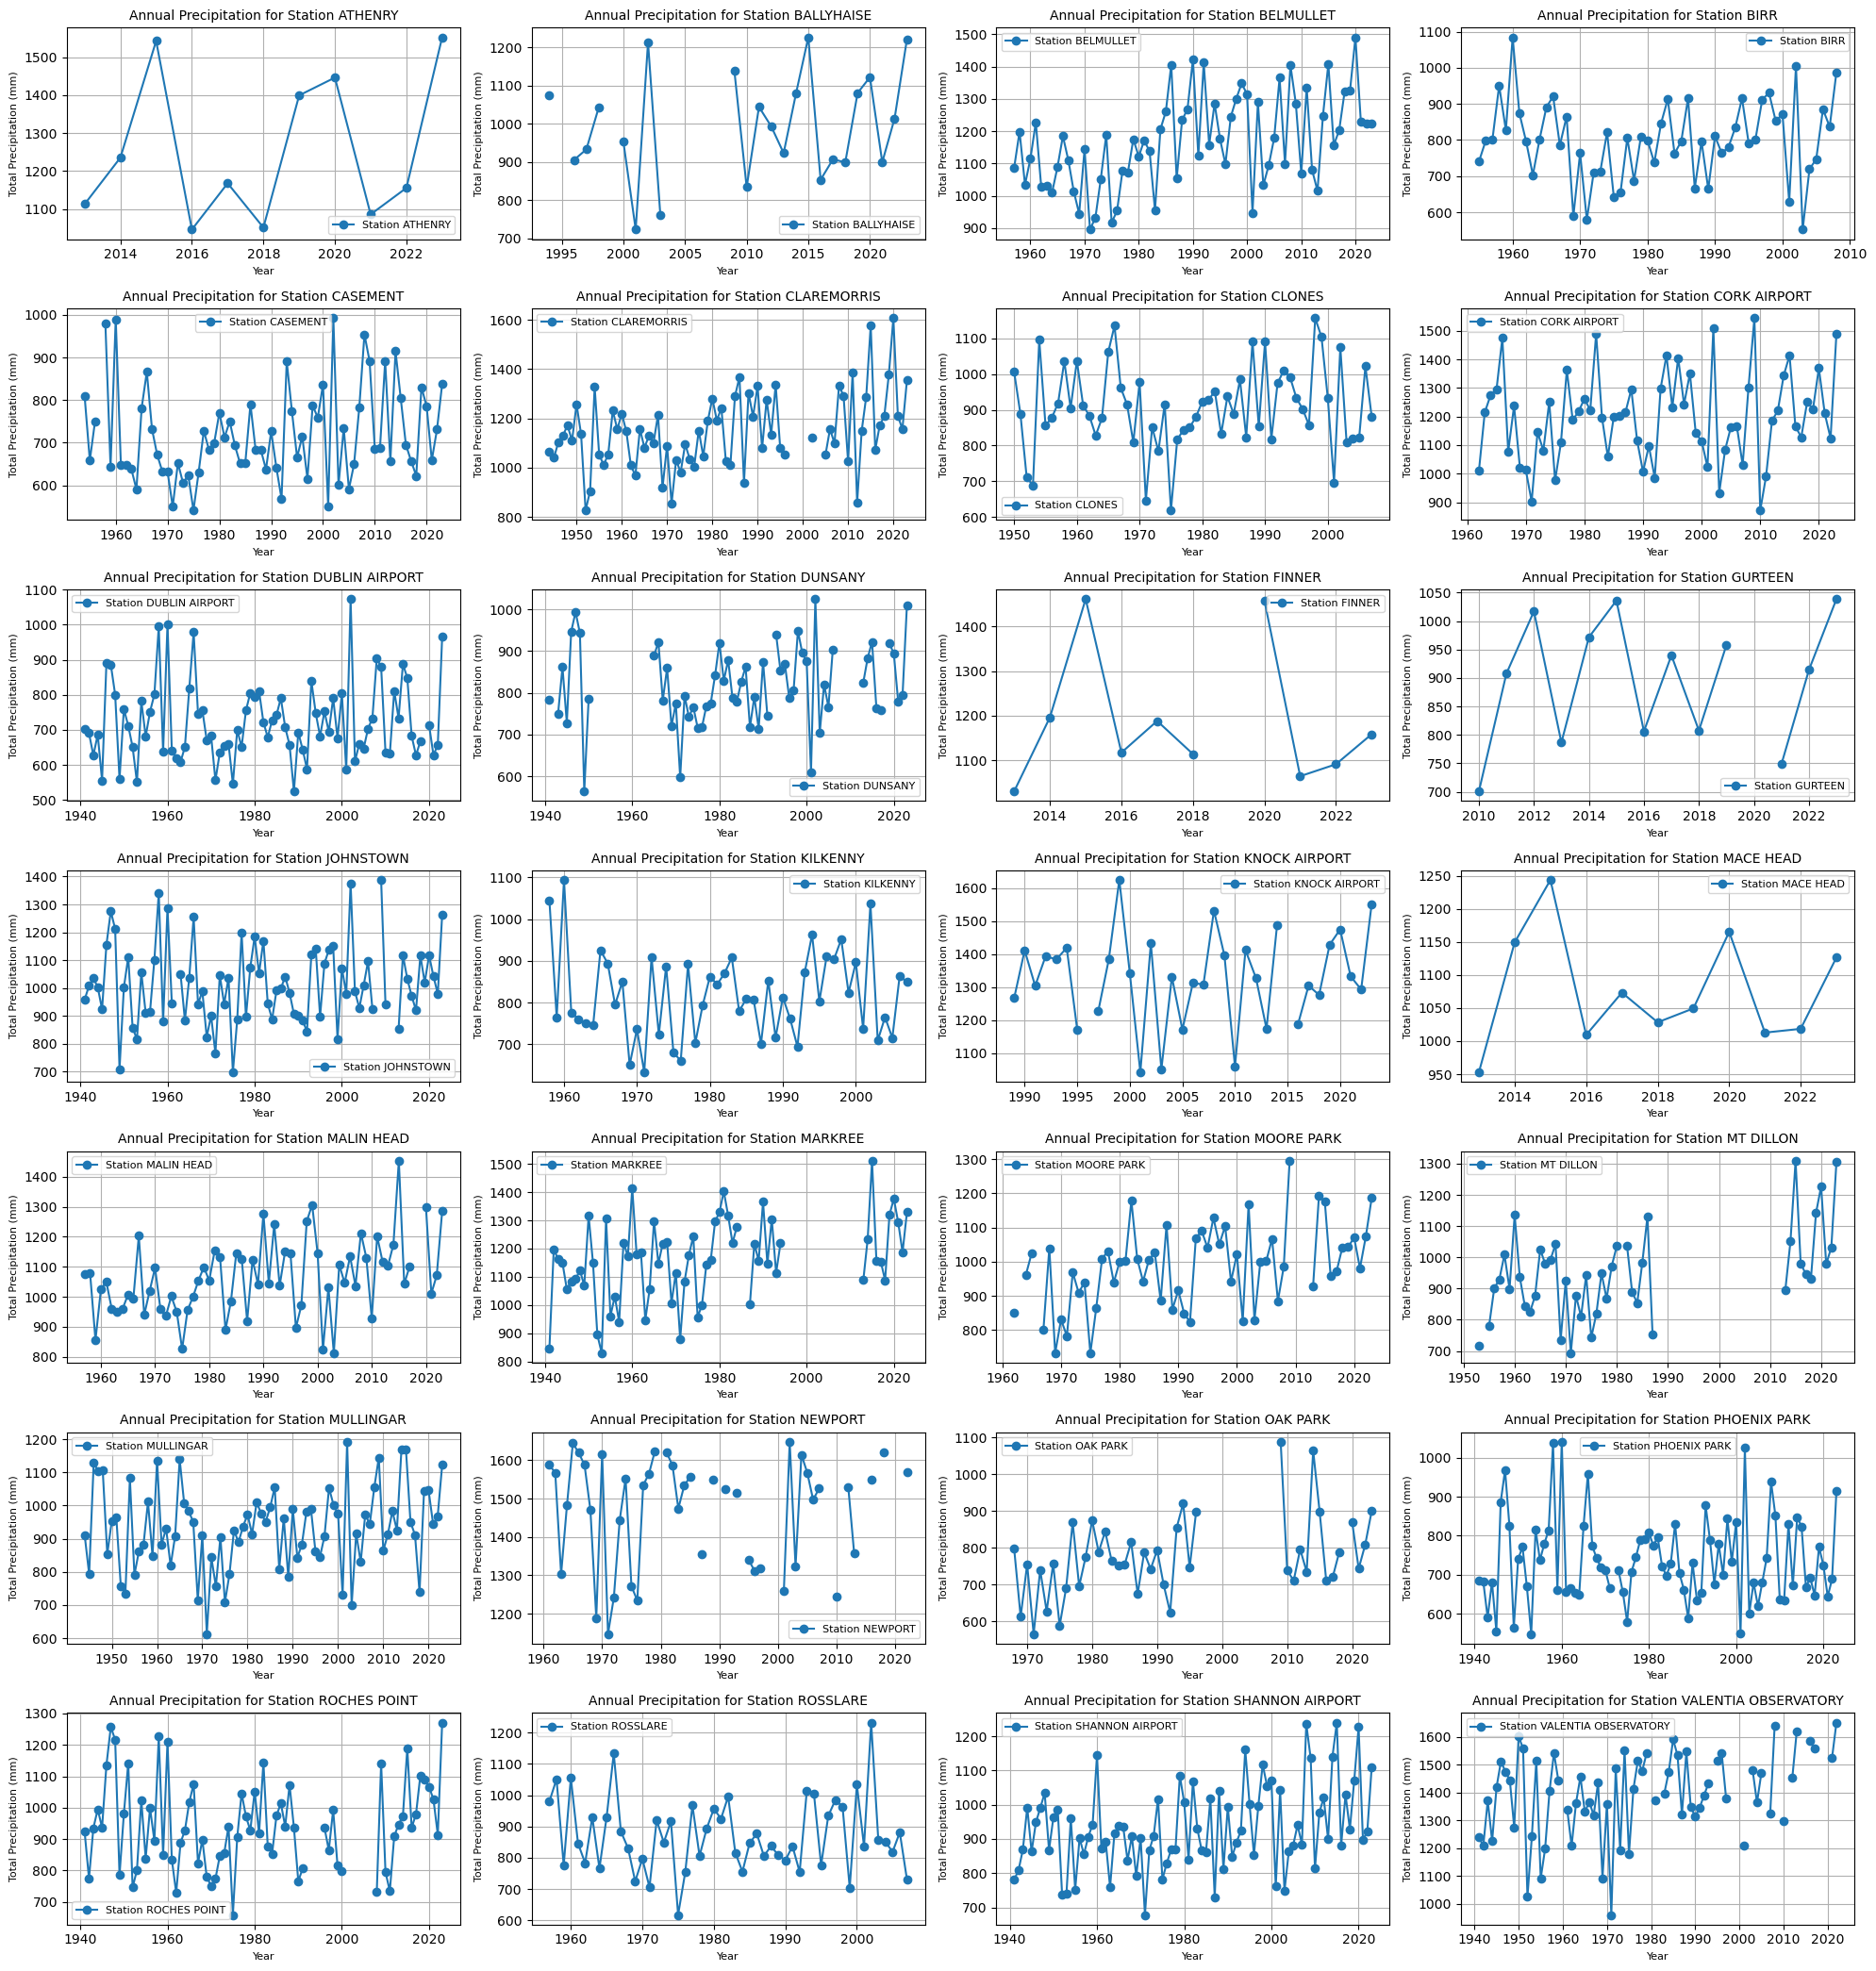

In [68]:
# Group by 'Station' and 'Year' and sum the 'Precipitation'
annual_precipitation = cleaned_df.groupby(['Station ID', 'year'])['PRCPTOT'].sum().reset_index()

# Pivot for easier plotting (optional)
precipitation_pivot = annual_precipitation.pivot(index='year', columns='Station ID', values='PRCPTOT')

import matplotlib.pyplot as plt

# Number of plots
num_plots = len(precipitation_pivot.columns)
num_columns = 4
num_rows = (num_plots + 1) // num_columns  # This ensures there are enough rows even for an odd number of plots

# Create a figure and axes with the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 3 * num_rows))  # Adjust overall figsize as needed

# Flatten the axes array for easier iteration if it's 2D
axes = axes.flatten()

# Loop through each column in the pivot table and create a plot
for index, column in enumerate(precipitation_pivot.columns):
    ax = axes[index]
    ax.plot(precipitation_pivot.index, precipitation_pivot[column], marker='o', label=f'Station {column}')
    ax.set_title(f'Annual Precipitation for Station {column}', fontsize=10)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Total Precipitation (mm)', fontsize=8)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True)

# Hide any unused axes if the number of plots isn't exactly num_rows * num_columns
for index in range(len(precipitation_pivot.columns), len(axes)):
    axes[index].axis('off')

plt.tight_layout()
plt.savefig('annual_precipitation.png') 
plt.show()

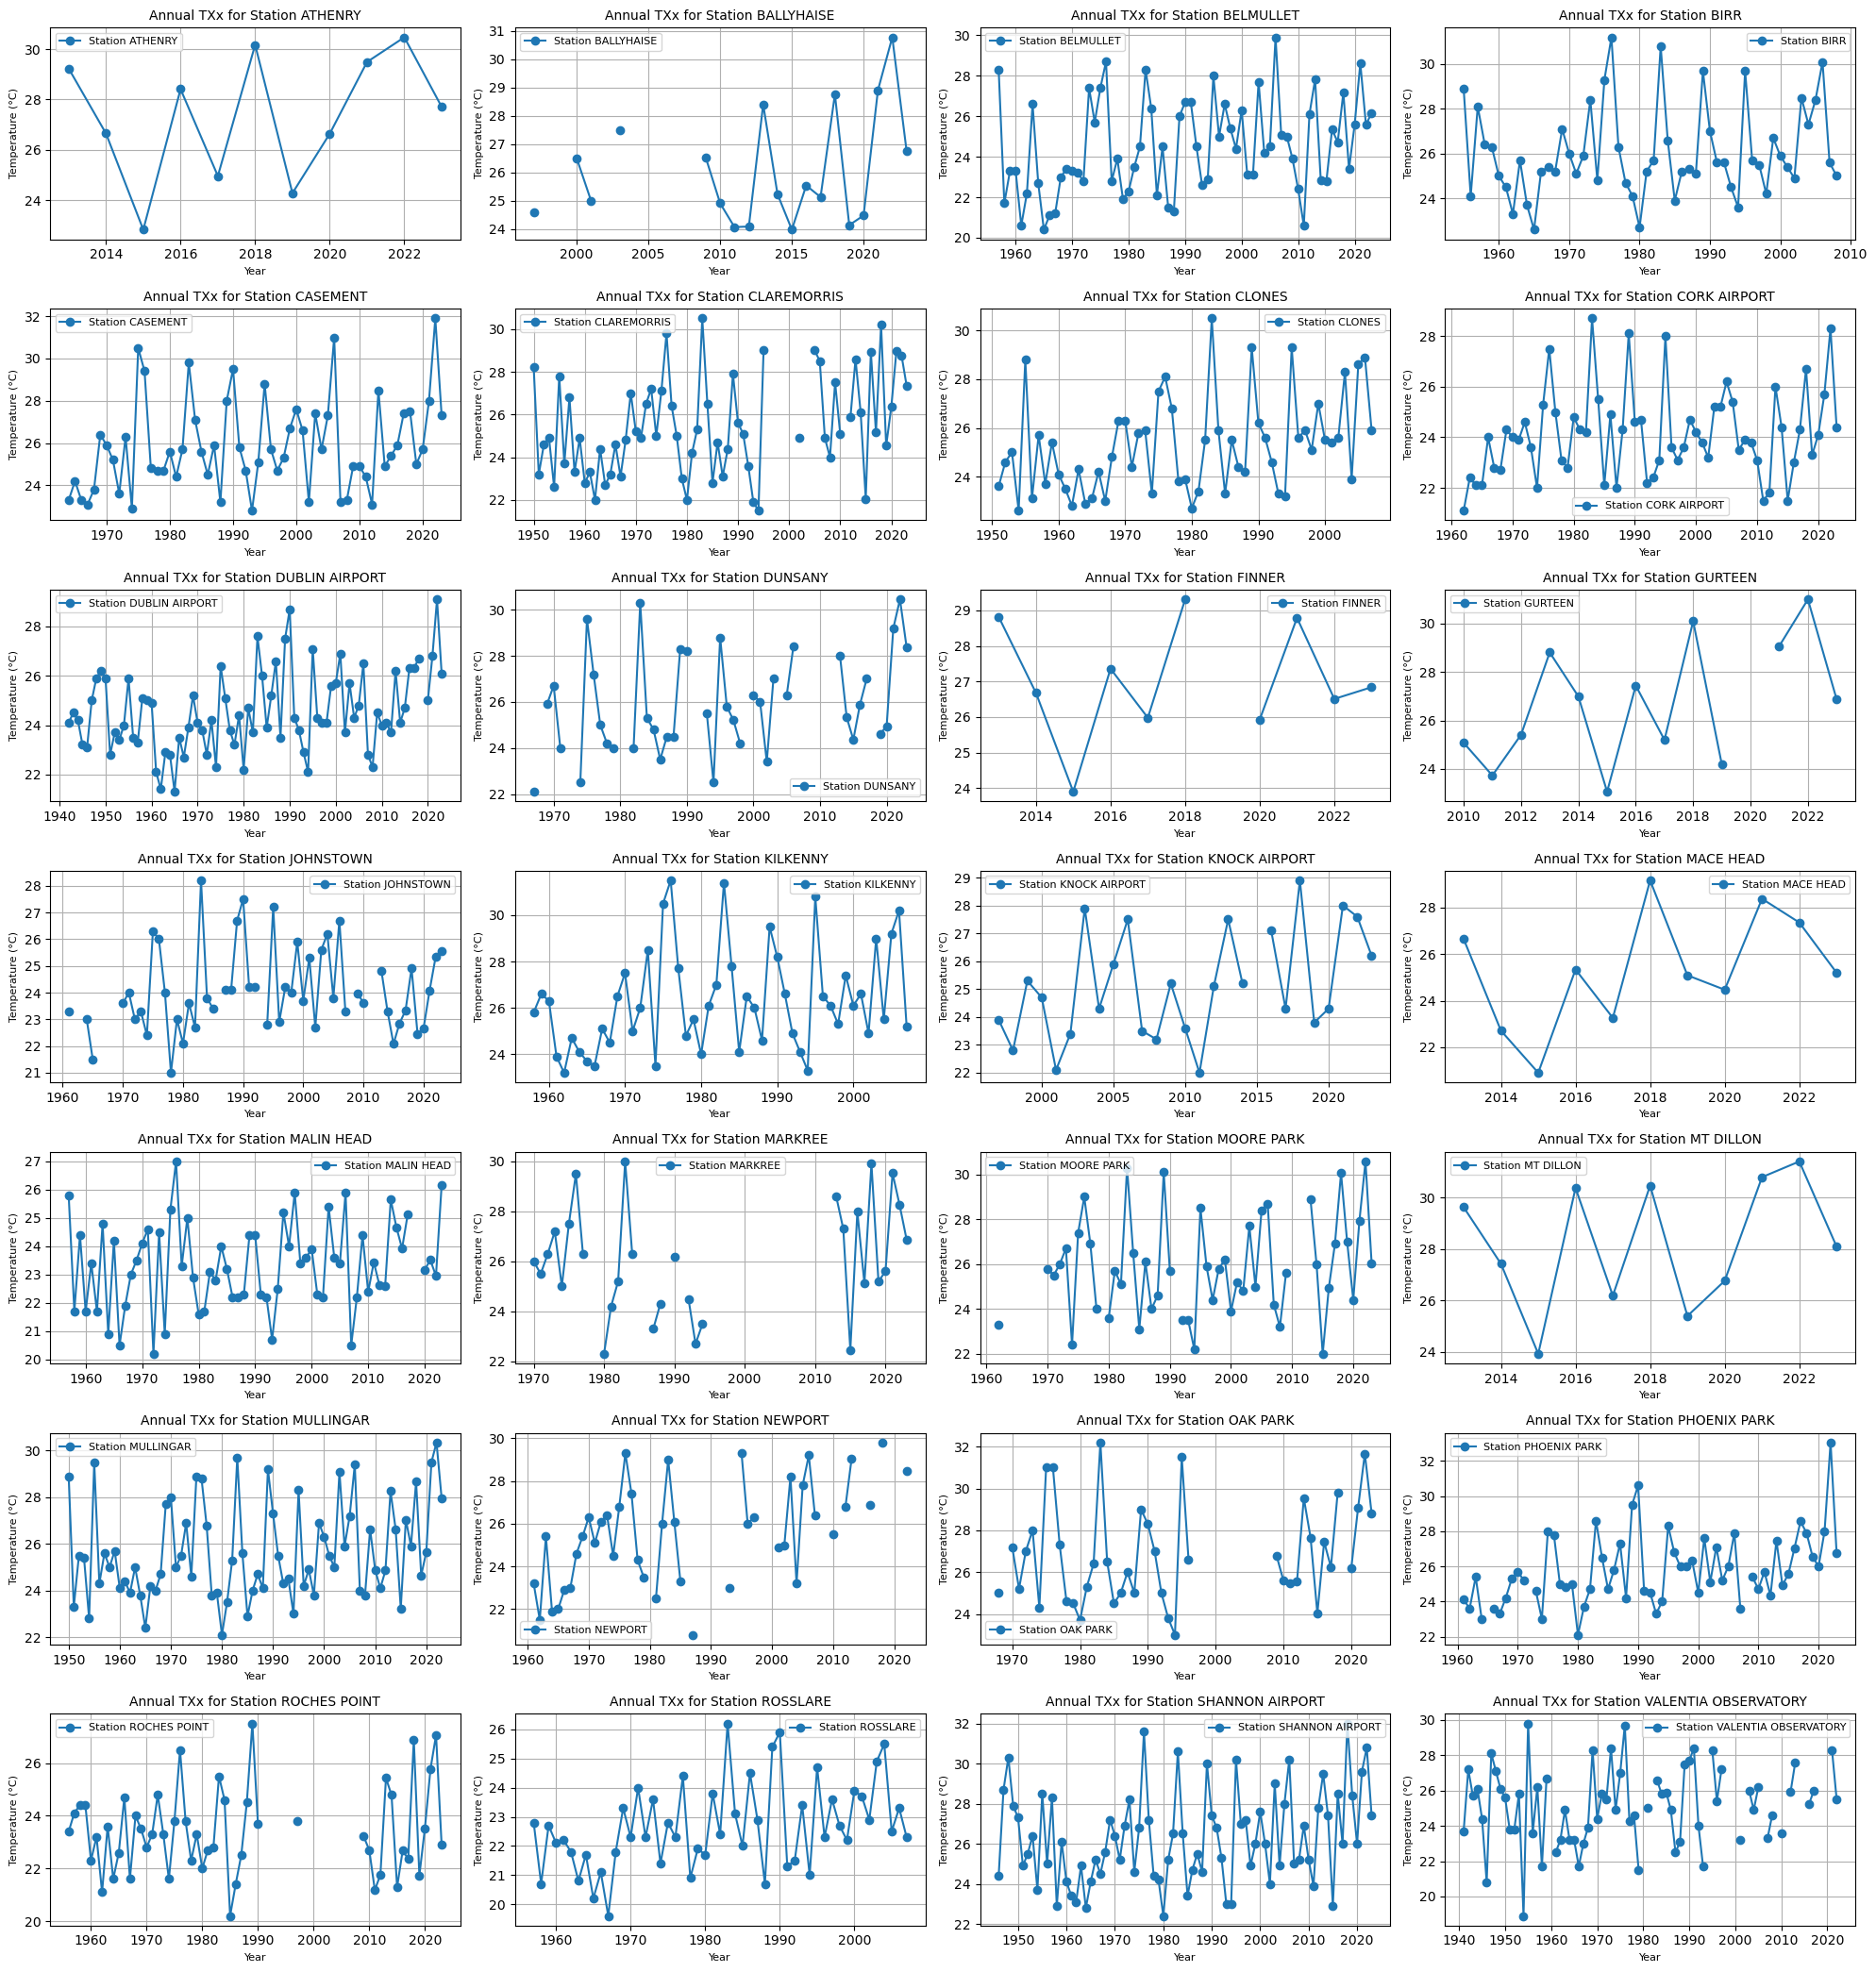

In [75]:
import matplotlib.pyplot as plt

# Group by 'Station' and 'Year' and find the maximum temperature
annual_max_temp = cleaned_df.groupby(['Station ID', 'year'])['TXx'].max().reset_index()

# Pivot for easier plotting (optional)
temperature_pivot = annual_max_temp.pivot(index='year', columns='Station ID', values='TXx')

# Number of plots
num_plots = len(temperature_pivot.columns)
num_columns = 4
num_rows = (num_plots + 1) // num_columns  # This ensures there are enough rows even for an odd number of plots

# Create a figure and axes with the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 3 * num_rows))  # Adjust overall figsize as needed

# Flatten the axes array for easier iteration if it's 2D
axes = axes.flatten()

# Loop through each column in the pivot table and create a plot
for index, column in enumerate(temperature_pivot.columns):
    ax = axes[index]
    ax.plot(temperature_pivot.index, temperature_pivot[column], marker='o', label=f'Station {column}')
    ax.set_title(f'Annual TXx for Station {column}', fontsize=10)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Temperature (°C)', fontsize=8)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True)

# Hide any unused axes if the number of plots isn't exactly num_rows * num_columns
for index in range(len(temperature_pivot.columns), len(axes)):
    axes[index].axis('off')

plt.tight_layout()

# Save the figure to a file
plt.savefig('annual_max_temperature.png')  # You can change the filename as needed

# Display the figure
plt.show()


In [76]:
# Merge the DataFrames on the Station_ID column
result_df0 = pd.merge(station_max_precipitation, cleaned_df[['Station ID', 'Direction']], on='Station ID', how='left')

print(result_df0)

                Station ID  PRCPTOT   Direction
0                  ATHENRY   1552.7  north-west
1                  ATHENRY   1552.7  north-west
2                  ATHENRY   1552.7  north-west
3                  ATHENRY   1552.7  north-west
4                  ATHENRY   1552.7  north-west
...                    ...      ...         ...
1500  VALENTIA OBSERVATORY   1651.7  south-west
1501  VALENTIA OBSERVATORY   1651.7  south-west
1502  VALENTIA OBSERVATORY   1651.7  south-west
1503  VALENTIA OBSERVATORY   1651.7  south-west
1504  VALENTIA OBSERVATORY   1651.7  south-west

[1505 rows x 3 columns]


In [77]:
# Step 1: Remove duplicates based on 'Station ID'
unique_stations = cleaned_df.drop_duplicates(subset='Station ID')


In [78]:
# Step 2: Merge the DataFrames on the 'Station ID' column
result_df = pd.merge(station_max_precipitation, unique_stations[['Station ID', 'Direction']], on='Station ID', how='left')
result_df

Station ID  PRCPTOT      Direction
0                ATHENRY   1552.7     north-west
1             BALLYHAISE   1226.6     north-east
2              BELMULLET   1490.8     north-west
3                   BIRR   1084.3     south-east
4               CASEMENT    992.4     north-east
5            CLAREMORRIS   1606.4     north-west
6                 CLONES   1156.8     north-east
7           CORK AIRPORT   1544.4     south-west
8         DUBLIN AIRPORT   1073.0     north-east
9                DUNSANY   1024.4     north-east
10                FINNER   1461.9     north-west
11               GURTEEN   1038.7  south-central
12             JOHNSTOWN   1387.7     south-east
13              KILKENNY   1093.6     south-east
14         KNOCK AIRPORT   1625.0     north-west
15             MACE HEAD   1243.7     north-west
16            MALIN HEAD   1453.3     north-east
17               MARKREE   1510.7     north-west
18            MOORE PARK   1295.3     south-west
19             MT DILLON   1309.1  north-central
20             MULLINGAR   1192.1     north-east
21               NEWPORT   1647.9     north-west
22              OAK PARK   1088.6     south-east
23          PHOENIX PARK   1041.3     north-east
24          ROCHES POINT   1270.8     south-west
25              ROSSLARE   1231.7     south-east
26       SHANNON AIRPORT   1239.7     south-west
27  VALENTIA OBSERVATORY   1651.7     south-west

In [79]:
result_df['Direction'].unique()

array(['north-west', 'north-east', 'south-east', 'south-west',
       'south-central', 'north-central'], dtype=object)

In [80]:
# Step 3: Group by 'Direction' (Region) and calculate the mean of 'Max Precipitation'
regional_avg = result_df.groupby('Direction')['PRCPTOT'].mean().reset_index()

# Rename columns for clarity (optional)
regional_avg.columns = ['Region', 'Avg Max Precipitation']

print(regional_avg)

          Region  Avg Max Precipitation
0  north-central              1309.1000
1     north-east              1144.9875
2     north-west              1517.3875
3  south-central              1038.7000
4     south-east              1177.1800
5     south-west              1400.3800


In [81]:
regional_avg_by_year = cleaned_df.groupby(['Direction', 'year'])[precipitation_column].mean().reset_index()
regional_avg_by_year.columns = ['Region', 'Year', 'Avg Max Precipitation']
print(regional_avg_by_year)

            Region  Year  Avg Max Precipitation
0    north-central  1953                717.800
1    north-central  1955                781.400
2    north-central  1956                900.700
3    north-central  1957                929.300
4    north-central  1958               1008.600
..             ...   ...                    ...
384     south-west  2019               1107.650
385     south-west  2020               1183.275
386     south-west  2021               1128.100
387     south-west  2022               1137.020
388     south-west  2023               1264.325

[389 rows x 3 columns]


In [82]:
# Assuming cleaned_df is your DataFrame with columns 'Direction', 'year', 'PRCPTOT', and 'TXx'

# Define the columns of interest
precipitation_column = 'PRCPTOT'
temperature_column = 'TXx'

# Group data by 'Direction' (Region) and 'year', then calculate the mean for both precipitation and TXx
regional_avg_by_year = cleaned_df.groupby(['Direction', 'year'])[[precipitation_column, temperature_column]].mean().reset_index()

# Rename the columns appropriately
regional_avg_by_year.columns = ['Region', 'Year', 'Avg Max Precipitation', 'Avg Max Temp']

# Display the DataFrame
print(regional_avg_by_year)


            Region  Year  Avg Max Precipitation  Avg Max Temp
0    north-central  1953                717.800           NaN
1    north-central  1955                781.400           NaN
2    north-central  1956                900.700           NaN
3    north-central  1957                929.300           NaN
4    north-central  1958               1008.600           NaN
..             ...   ...                    ...           ...
384     south-west  2019               1107.650        25.105
385     south-west  2020               1183.275        24.510
386     south-west  2021               1128.100        27.460
387     south-west  2022               1137.020        28.454
388     south-west  2023               1264.325        25.185

[389 rows x 4 columns]


In [83]:
# Save the DataFrame to a CSV file
regional_avg_by_year.to_csv('temaprature.csv', index=False)

In [84]:
regional_avg_by_year.columns

Index(['Region', 'Year', 'Avg Max Precipitation', 'Avg Max Temp'], dtype='object')

In [85]:
# Assuming the regional_avg_by_year DataFrame is already created as per your previous code

# Group data by 'Region' to calculate the overall average for 'Avg Max Temp'
avg_max_temp_by_region = regional_avg_by_year.groupby('Region')['Avg Max Temp'].mean().reset_index()

# Rename the column to match the format you're looking for
avg_max_temp_by_region.columns = ['Region', 'Avg Max Temp']

# Display the result
print(avg_max_temp_by_region)


          Region  Avg Max Temp
0  north-central     28.228182
1     north-east     25.028242
2     north-west     25.023113
3  south-central     26.688462
4     south-east     25.150338
5     south-west     25.071878


In [86]:
# Group data by 'Region' to calculate the overall average for 'Avg Max Precipitation'
avg_max_precipitation_by_region = regional_avg_by_year.groupby('Region')['Avg Max Precipitation'].mean().reset_index()

# Rename the column to match the desired format
avg_max_precipitation_by_region.columns = ['Region', 'Avg Precipitation']

# Display the result
print(avg_max_precipitation_by_region)


          Region  Avg Precipitation
0  north-central         947.856818
1     north-east         837.575666
2     north-west        1208.308670
3  south-central         894.784615
4     south-east         900.580341
5     south-west        1083.265181


In [87]:
average_precipitation_by_region = regional_avg_by_year.groupby('Region')['Avg Max Precipitation'].mean().reset_index()

This code generates individual temperature trend plots for each region, with each plot displayed in its own figure. The temperature data points are shown as circular markers connected by lines. Titles, axis labels, and legends are provided for clarity, making it easy to observe and compare the temperature trends over time for each region.

In [88]:
print(regional_avg_by_year.groupby('Region')['Year'].nunique())

Region
north-central    44
north-east       83
north-west       83
south-central    13
south-east       83
south-west       83
Name: Year, dtype: int64


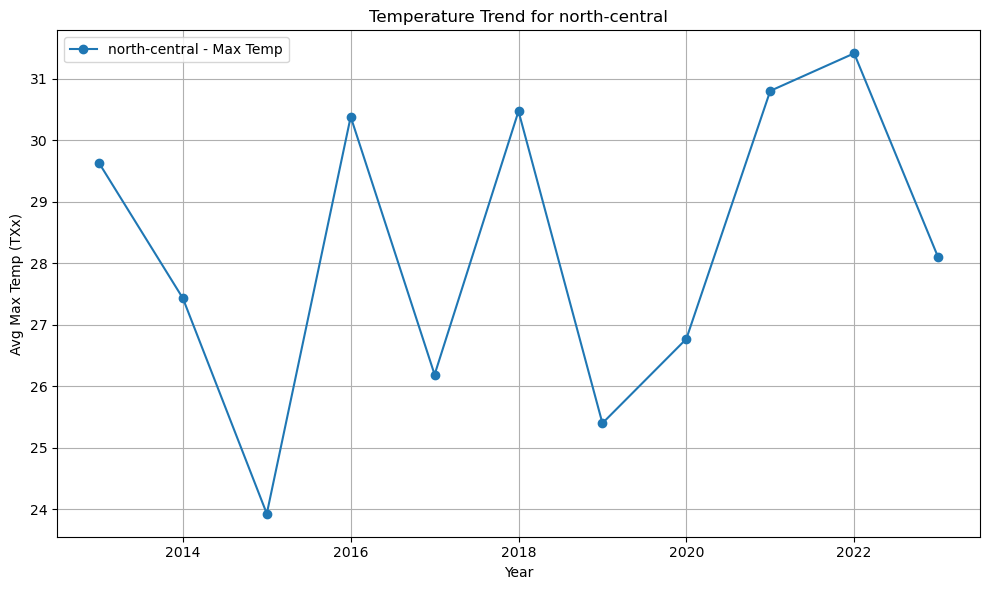

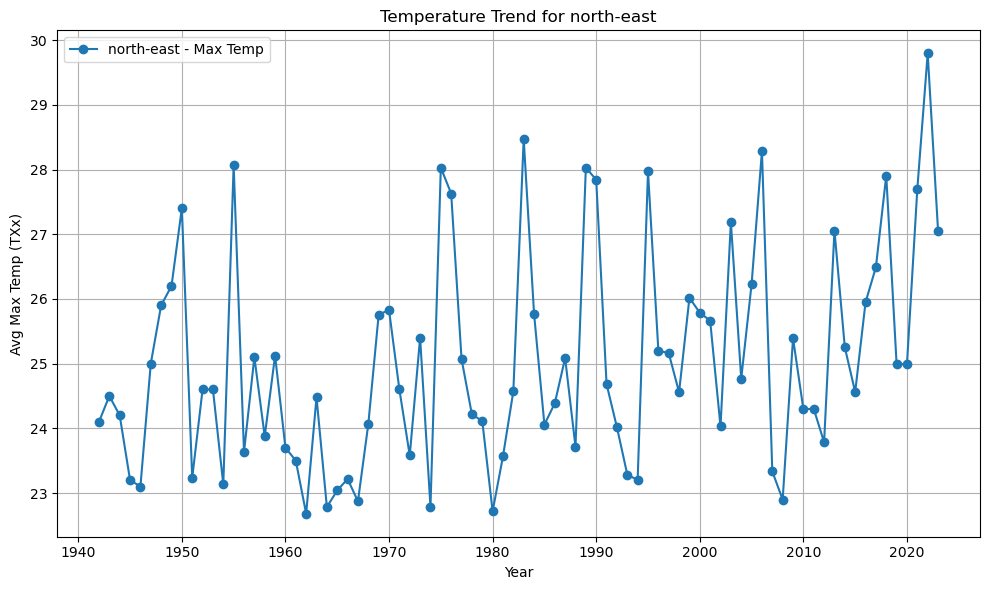

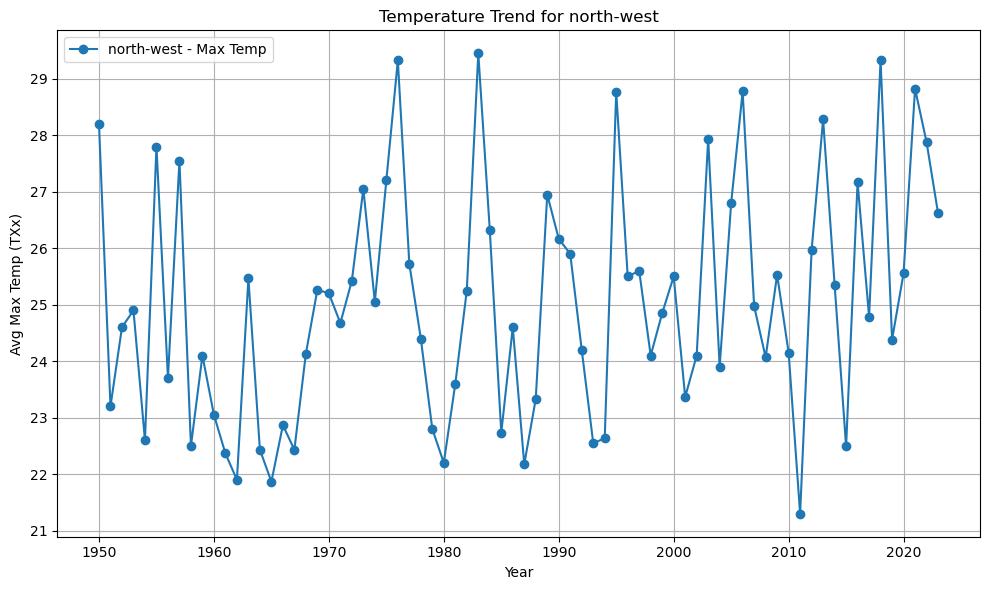

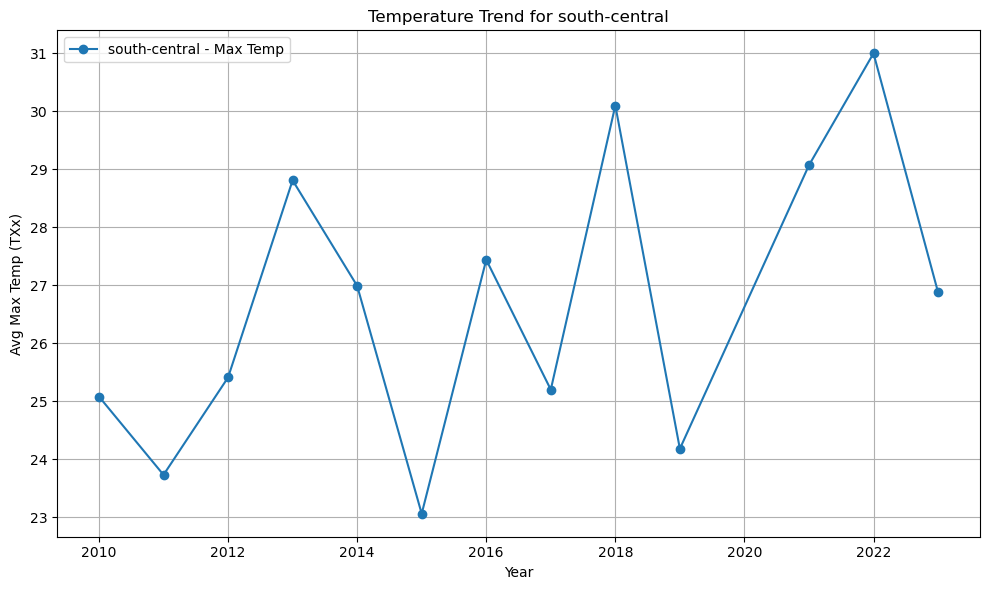

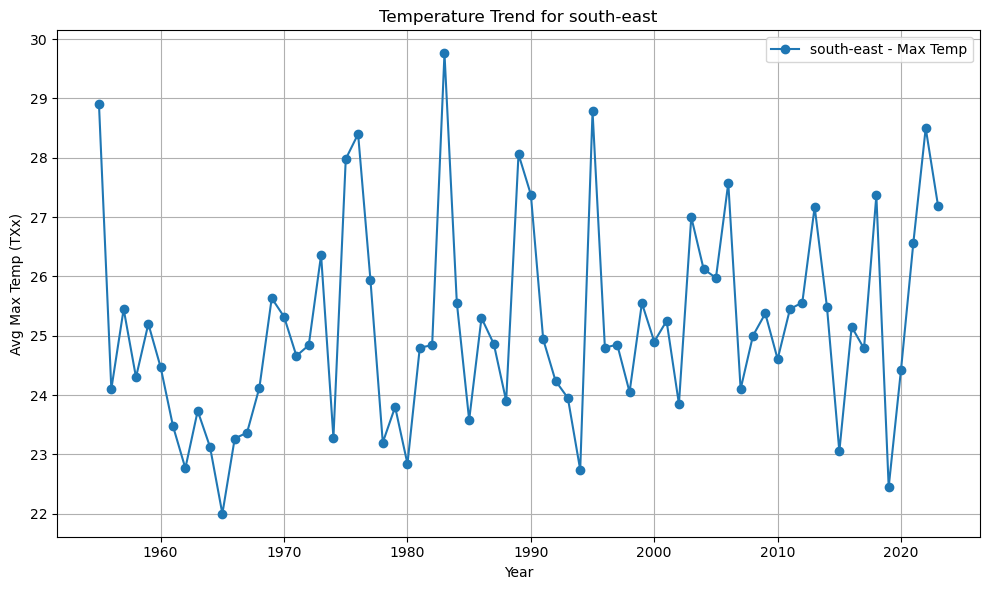

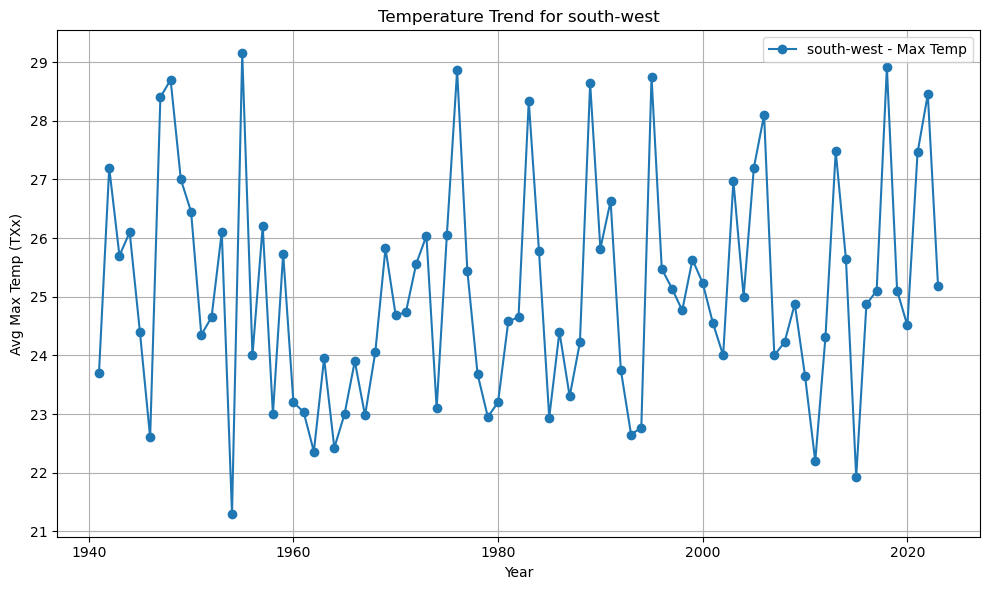

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'regional_avg_by_year' is your DataFrame that contains the regional average data
# with columns ['Region', 'Year', 'Avg Max Temp']

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Iterate over each region and plot the temperature trend separately
for region in regions:
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Create a figure for each region
    plt.figure(figsize=(10, 6))

    # Plot Temperature Trend
    plt.plot(region_data['Year'], region_data['Avg Max Temp'], marker='o', label=f'{region} - Max Temp')
    plt.xlabel('Year')
    plt.ylabel('Avg Max Temp (TXx)')
    plt.title(f'Temperature Trend for {region}')
    plt.legend(loc='best')
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


The below code represents individual temperature trend plots for each region, with a baseline included for reference.

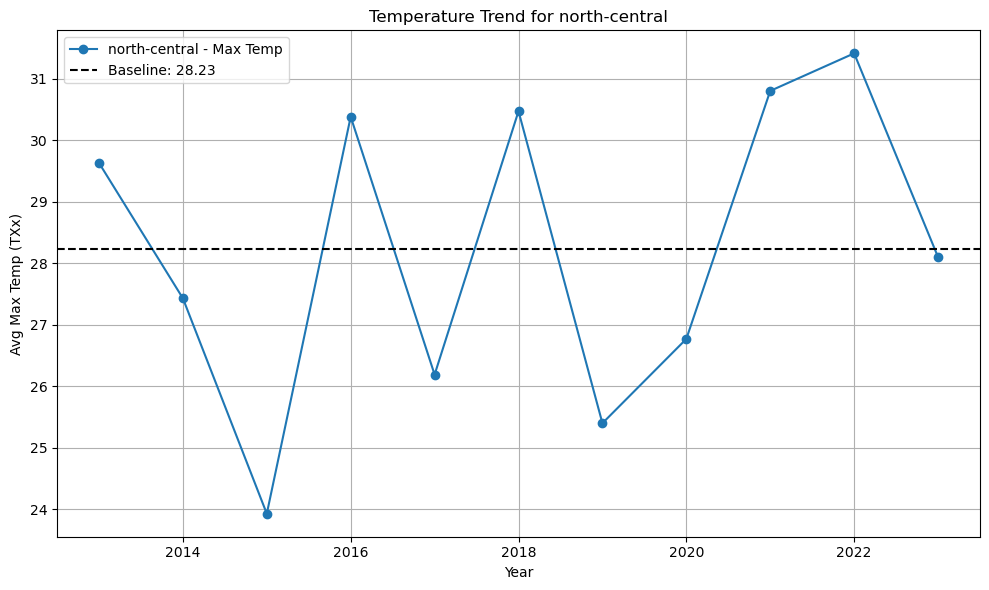

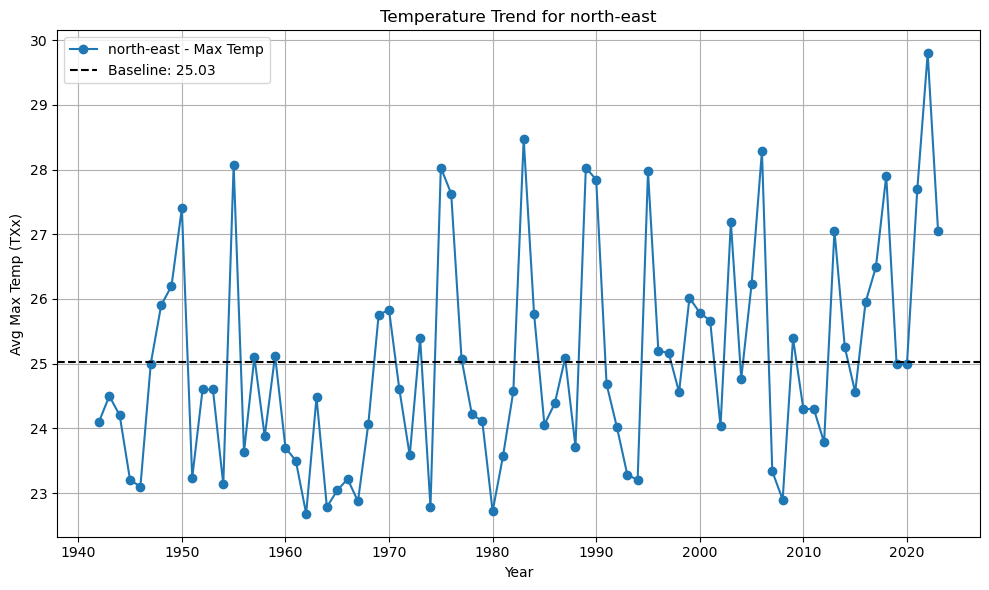

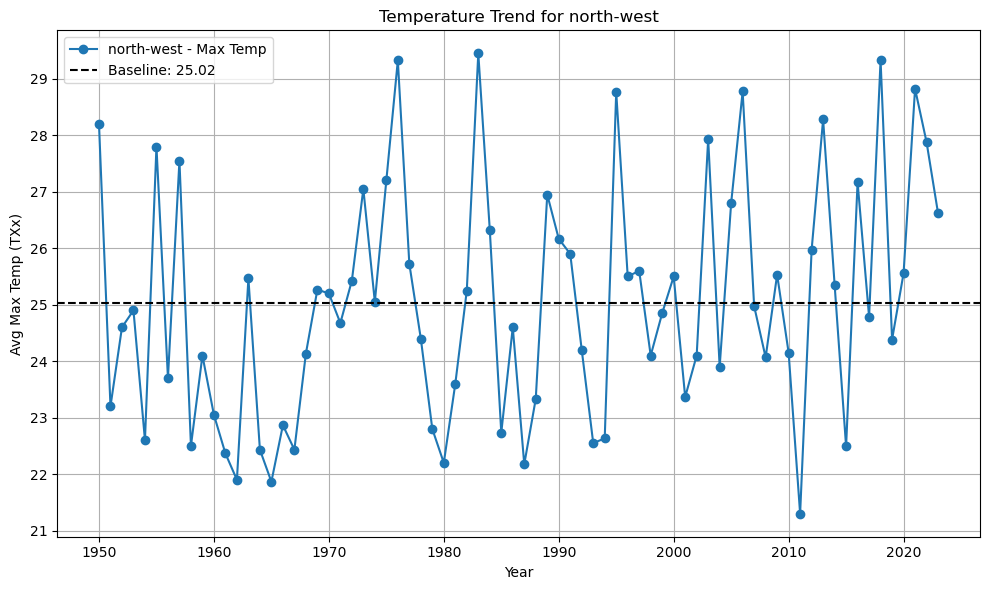

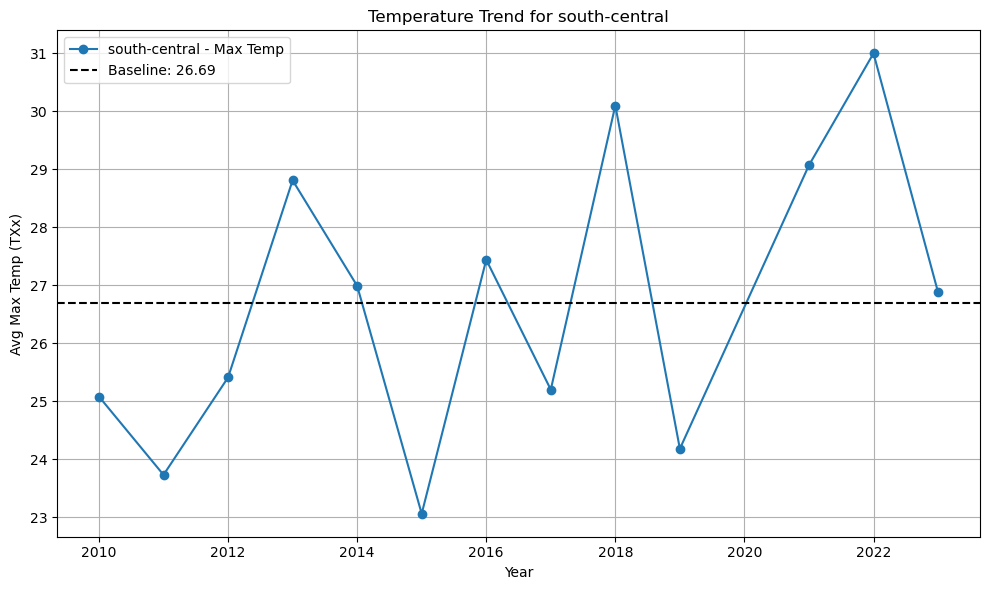

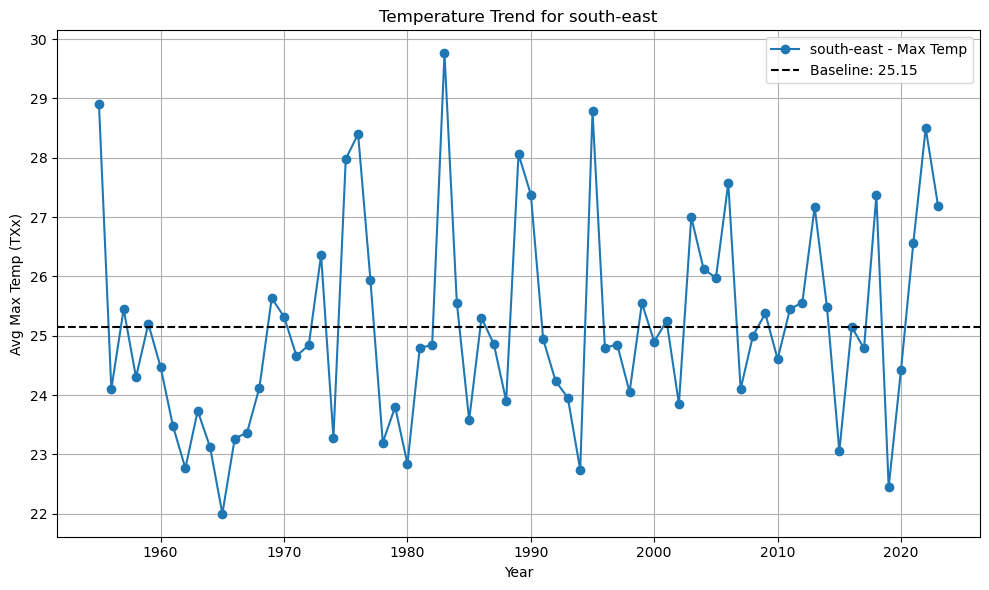

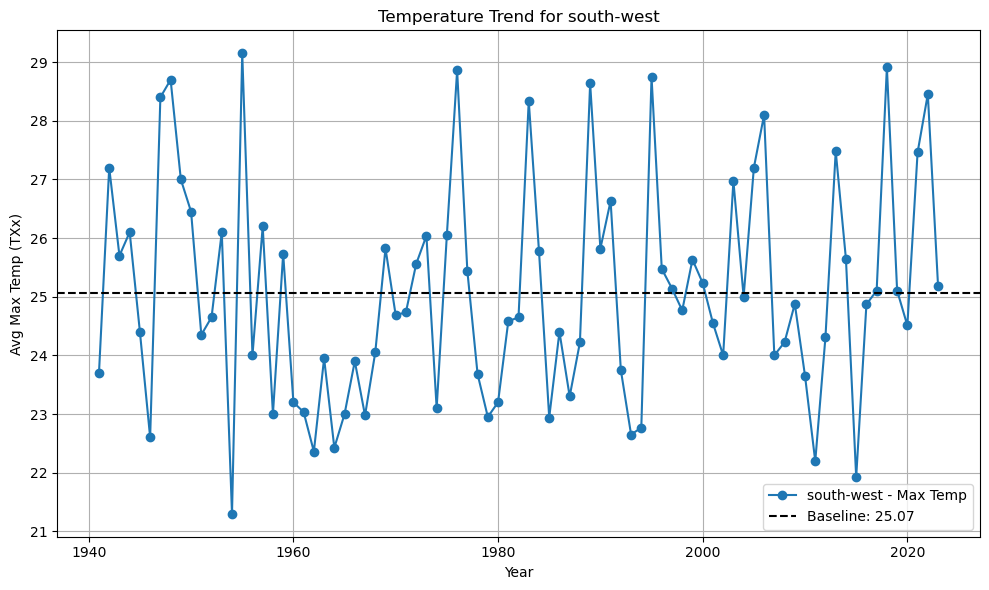

In [90]:

# Assuming 'regional_avg_by_year' is your DataFrame that contains the regional average data
# with columns ['Region', 'Year', 'Avg Max Temp']

# Baseline values for Avg Max Temp
temperature_baseline = pd.DataFrame({
    'Region': ['north-central', 'north-east', 'north-west', 'south-central', 'south-east', 'south-west'],
    'Avg Max Temp': [28.228182, 25.028242, 25.023113, 26.688462, 25.150338, 25.071878]
})

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Iterate over each region and plot the temperature trend separately
for region in regions:
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Get the baseline temperature for the current region
    baseline = temperature_baseline[temperature_baseline['Region'] == region]['Avg Max Temp'].values[0]

    # Create a figure for each region
    plt.figure(figsize=(10, 6))

    # Plot Temperature Trend
    plt.plot(region_data['Year'], region_data['Avg Max Temp'], marker='o', label=f'{region} - Max Temp')

    # Add baseline line
    plt.axhline(y=baseline, color='black', linestyle='--', label=f'Baseline: {baseline:.2f}')

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Avg Max Temp (TXx)')
    plt.title(f'Temperature Trend for {region}')
    plt.legend(loc='best')
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


In [91]:
average_precipitation_by_region

Region  Avg Max Precipitation
0  north-central             947.856818
1     north-east             837.575666
2     north-west            1208.308670
3  south-central             894.784615
4     south-east             900.580341
5     south-west            1083.265181

This code generates a series of vertically stacked subplots, each showing the trend of "Average Max Precipitation" over time for different regions. Each subplot is color-coded for clarity, with different colors assigned to each region. Data points are represented by circular markers connected by lines, and each subplot includes a title indicating the region it represents

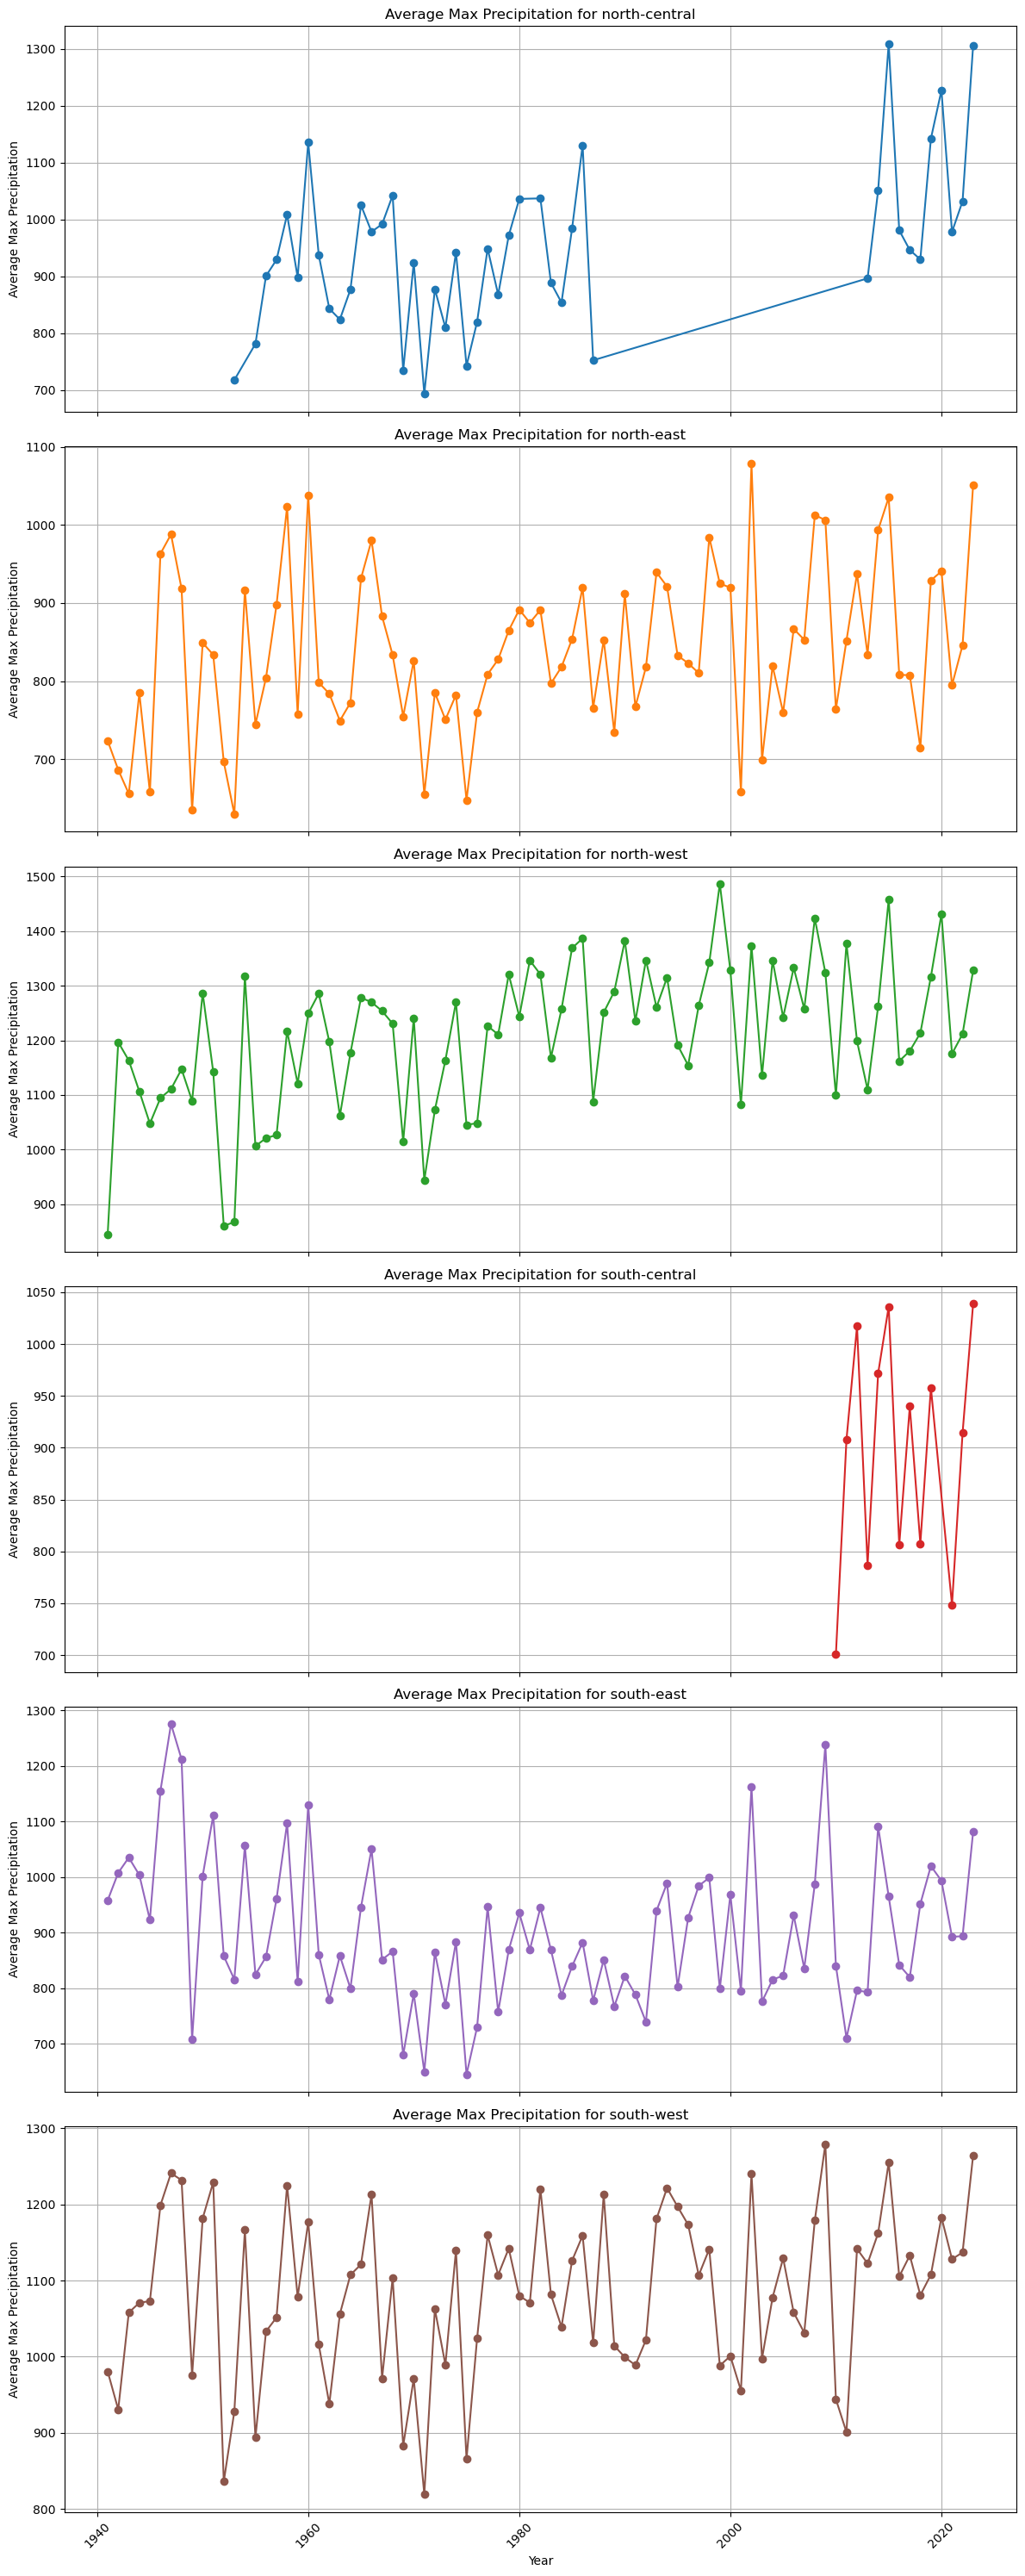

In [92]:
# Get unique regions and assign colors
regions = regional_avg_by_year['Region'].unique()
num_regions = len(regions)

# Define a color map
colors = plt.get_cmap('tab10')  # You can choose a colormap like 'tab10', 'viridis', etc.
color_list = colors(range(num_regions))

# Create subplots
fig, axes = plt.subplots(nrows=num_regions, ncols=1, figsize=(12, 5 * num_regions), sharex=True)

# Plot each region in a separate subplot with different colors
for i, (region, color) in enumerate(zip(regions, color_list)):
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]
    axes[i].plot(region_data['Year'], region_data['Avg Max Precipitation'], marker='o', color=color, label=region)
    axes[i].set_title(f'Average Max Precipitation for {region}')
    axes[i].set_ylabel('Average Max Precipitation')
    axes[i].grid(True)

# Set common x-label
axes[-1].set_xlabel('Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

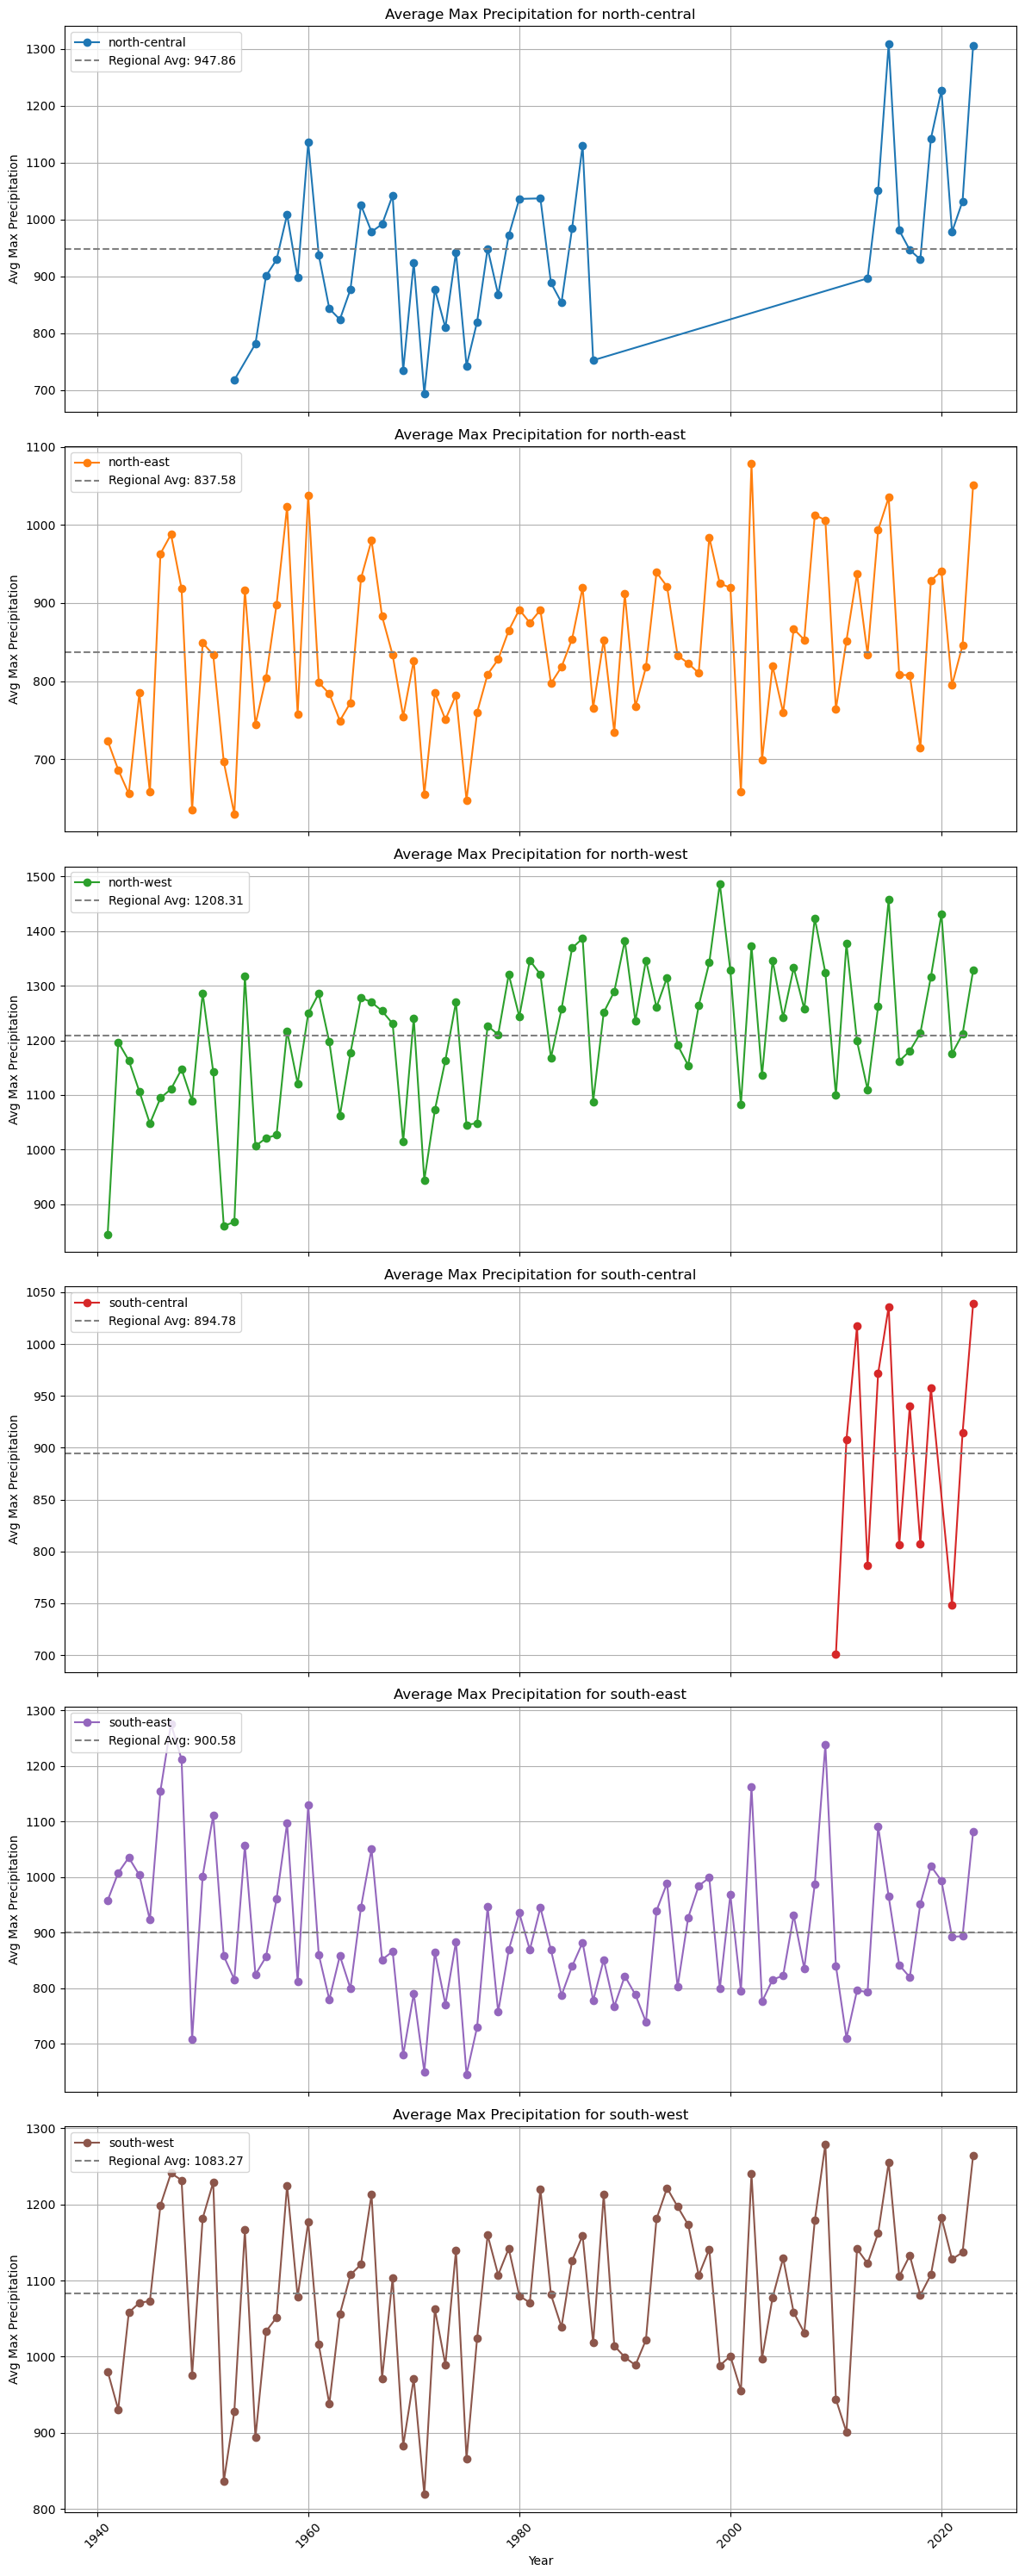

In [93]:
# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Define a color map
colors = plt.get_cmap('tab10')
color_list = colors(range(len(regions)))

# Create subplots
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(12, 5 * len(regions)), sharex=True)

# Plot each region in a separate subplot
for i, (region, color) in enumerate(zip(regions, color_list)):
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Plot yearly average max precipitation
    axes[i].plot(region_data['Year'], region_data['Avg Max Precipitation'], marker='o', color=color, label=region)

    # Add baseline
    baseline = average_precipitation_by_region[average_precipitation_by_region['Region'] == region]['Avg Max Precipitation'].values[0]
    axes[i].axhline(y=baseline, color='grey', linestyle='--', label=f'Regional Avg: {baseline:.2f}')

    # Set plot details
    axes[i].set_title(f'Average Max Precipitation for {region}')
    axes[i].set_ylabel('Avg Max Precipitation')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

# Set common x-label
axes[-1].set_xlabel('Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

This code creates subplots for each region, displaying "Average Max Precipitation" trends. Each subplot features color-coded lines, a baseline average precipitation line, and markers highlighting extreme wet (blue) and dry (red) years. Titles, axis labels, and legends enhance clarity, making it easy to compare precipitation patterns and extremes across regions.

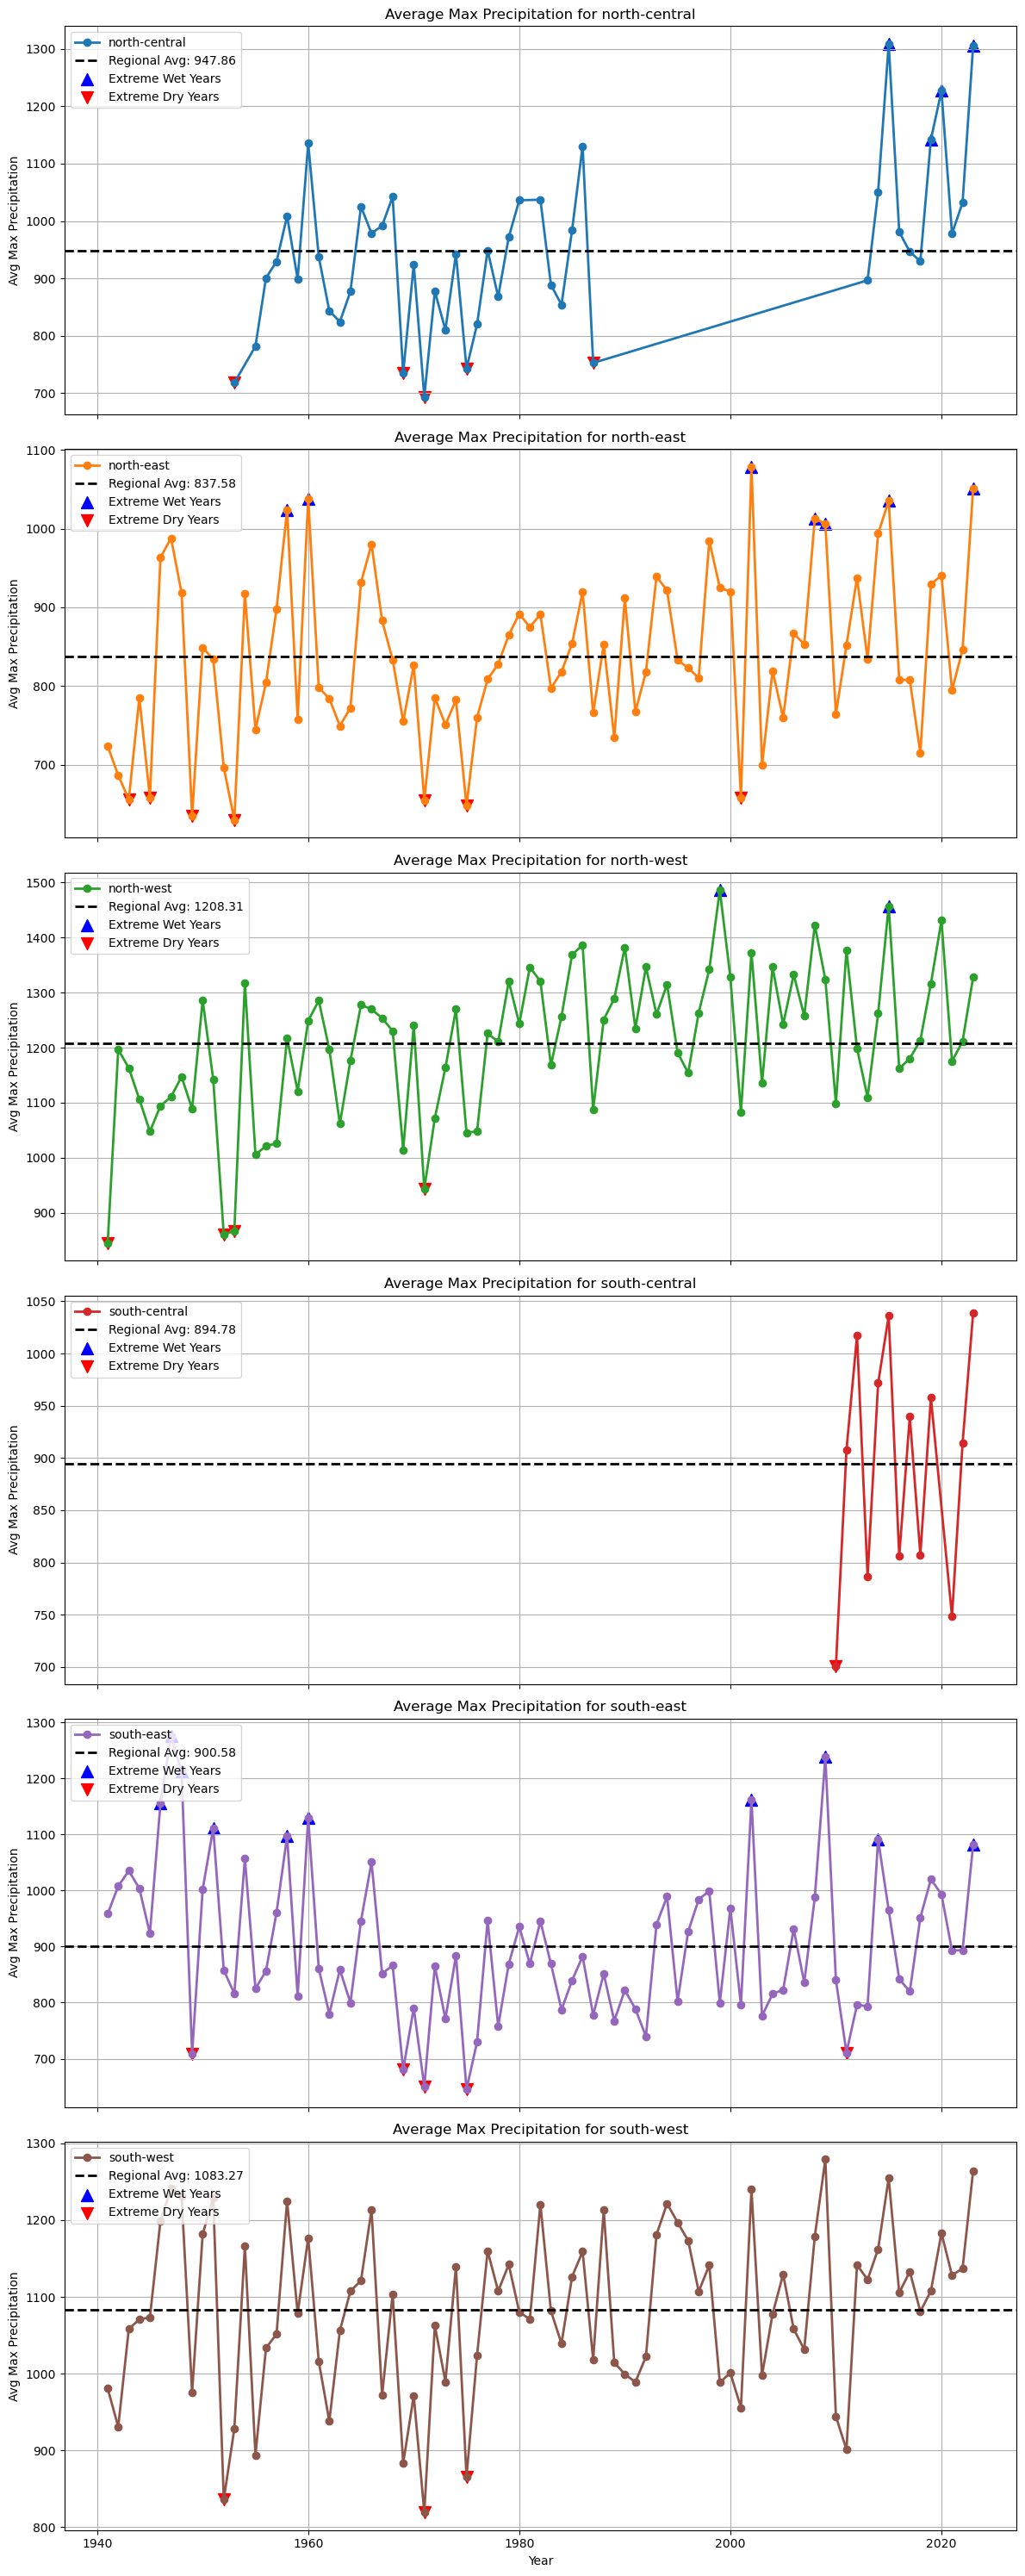

north-central - Extreme Wet Years: [2015, 2019, 2020, 2023]
north-central - Extreme Dry Years: [1953, 1969, 1971, 1975, 1987]
north-east - Extreme Wet Years: [1958, 1960, 2002, 2008, 2009, 2015, 2023]
north-east - Extreme Dry Years: [1943, 1945, 1949, 1953, 1971, 1975, 2001]
north-west - Extreme Wet Years: [1999, 2015]
north-west - Extreme Dry Years: [1941, 1952, 1953, 1971]
south-central - Extreme Wet Years: []
south-central - Extreme Dry Years: [2010]
south-east - Extreme Wet Years: [1946, 1947, 1948, 1951, 1958, 1960, 2002, 2009, 2014, 2023]
south-east - Extreme Dry Years: [1949, 1969, 1971, 1975, 2011]
south-west - Extreme Wet Years: []
south-west - Extreme Dry Years: [1952, 1971, 1975]


In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Define the threshold percentage
threshold_percentage = 20 / 100  # 20%

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Define a color map
colors = plt.get_cmap('tab10')
color_list = colors(np.arange(len(regions)))

# Create subplots
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(12, 5 * len(regions)), sharex=True)

# Dictionary to hold extreme years data
extreme_years_data = {}

# Plot each region in a separate subplot
for i, (region, color) in enumerate(zip(regions, color_list)):
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Plot yearly average max precipitation
    axes[i].plot(region_data['Year'], region_data['Avg Max Precipitation'], marker='o', color=color, label=region, linewidth=2)

    # Add baseline
    baseline = average_precipitation_by_region[average_precipitation_by_region['Region'] == region]['Avg Max Precipitation'].values[0]
    axes[i].axhline(y=baseline, color='black', linestyle='--', label=f'Regional Avg: {baseline:.2f}', linewidth=2)

    # Define thresholds
    extreme_wet_threshold = baseline * (1 + threshold_percentage)
    extreme_dry_threshold = baseline * (1 - threshold_percentage)

    # Highlight extreme wet years
    wet_years = region_data[region_data['Avg Max Precipitation'] > extreme_wet_threshold]
    axes[i].scatter(wet_years['Year'], wet_years['Avg Max Precipitation'], color='blue', marker='^', label='Extreme Wet Years', s=100)

    # Highlight extreme dry years
    dry_years = region_data[region_data['Avg Max Precipitation'] < extreme_dry_threshold]
    axes[i].scatter(dry_years['Year'], dry_years['Avg Max Precipitation'], color='red', marker='v', label='Extreme Dry Years', s=100)

    # Collect extreme years
    extreme_years_data[region] = {
        'Extreme Wet Years': wet_years['Year'].tolist(),
        'Extreme Dry Years': dry_years['Year'].tolist()
    }

    # Set plot details
    axes[i].set_title(f'Average Max Precipitation for {region}')
    axes[i].set_ylabel('Avg Max Precipitation')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

# Set common x-label
axes[-1].set_xlabel('Year')

plt.tight_layout()
plt.show()

# Print extreme years data
for region, years in extreme_years_data.items():
    print(f"{region} - Extreme Wet Years: {years['Extreme Wet Years']}")
    print(f"{region} - Extreme Dry Years: {years['Extreme Dry Years']}")


Text(0.5, 0, 'Year')

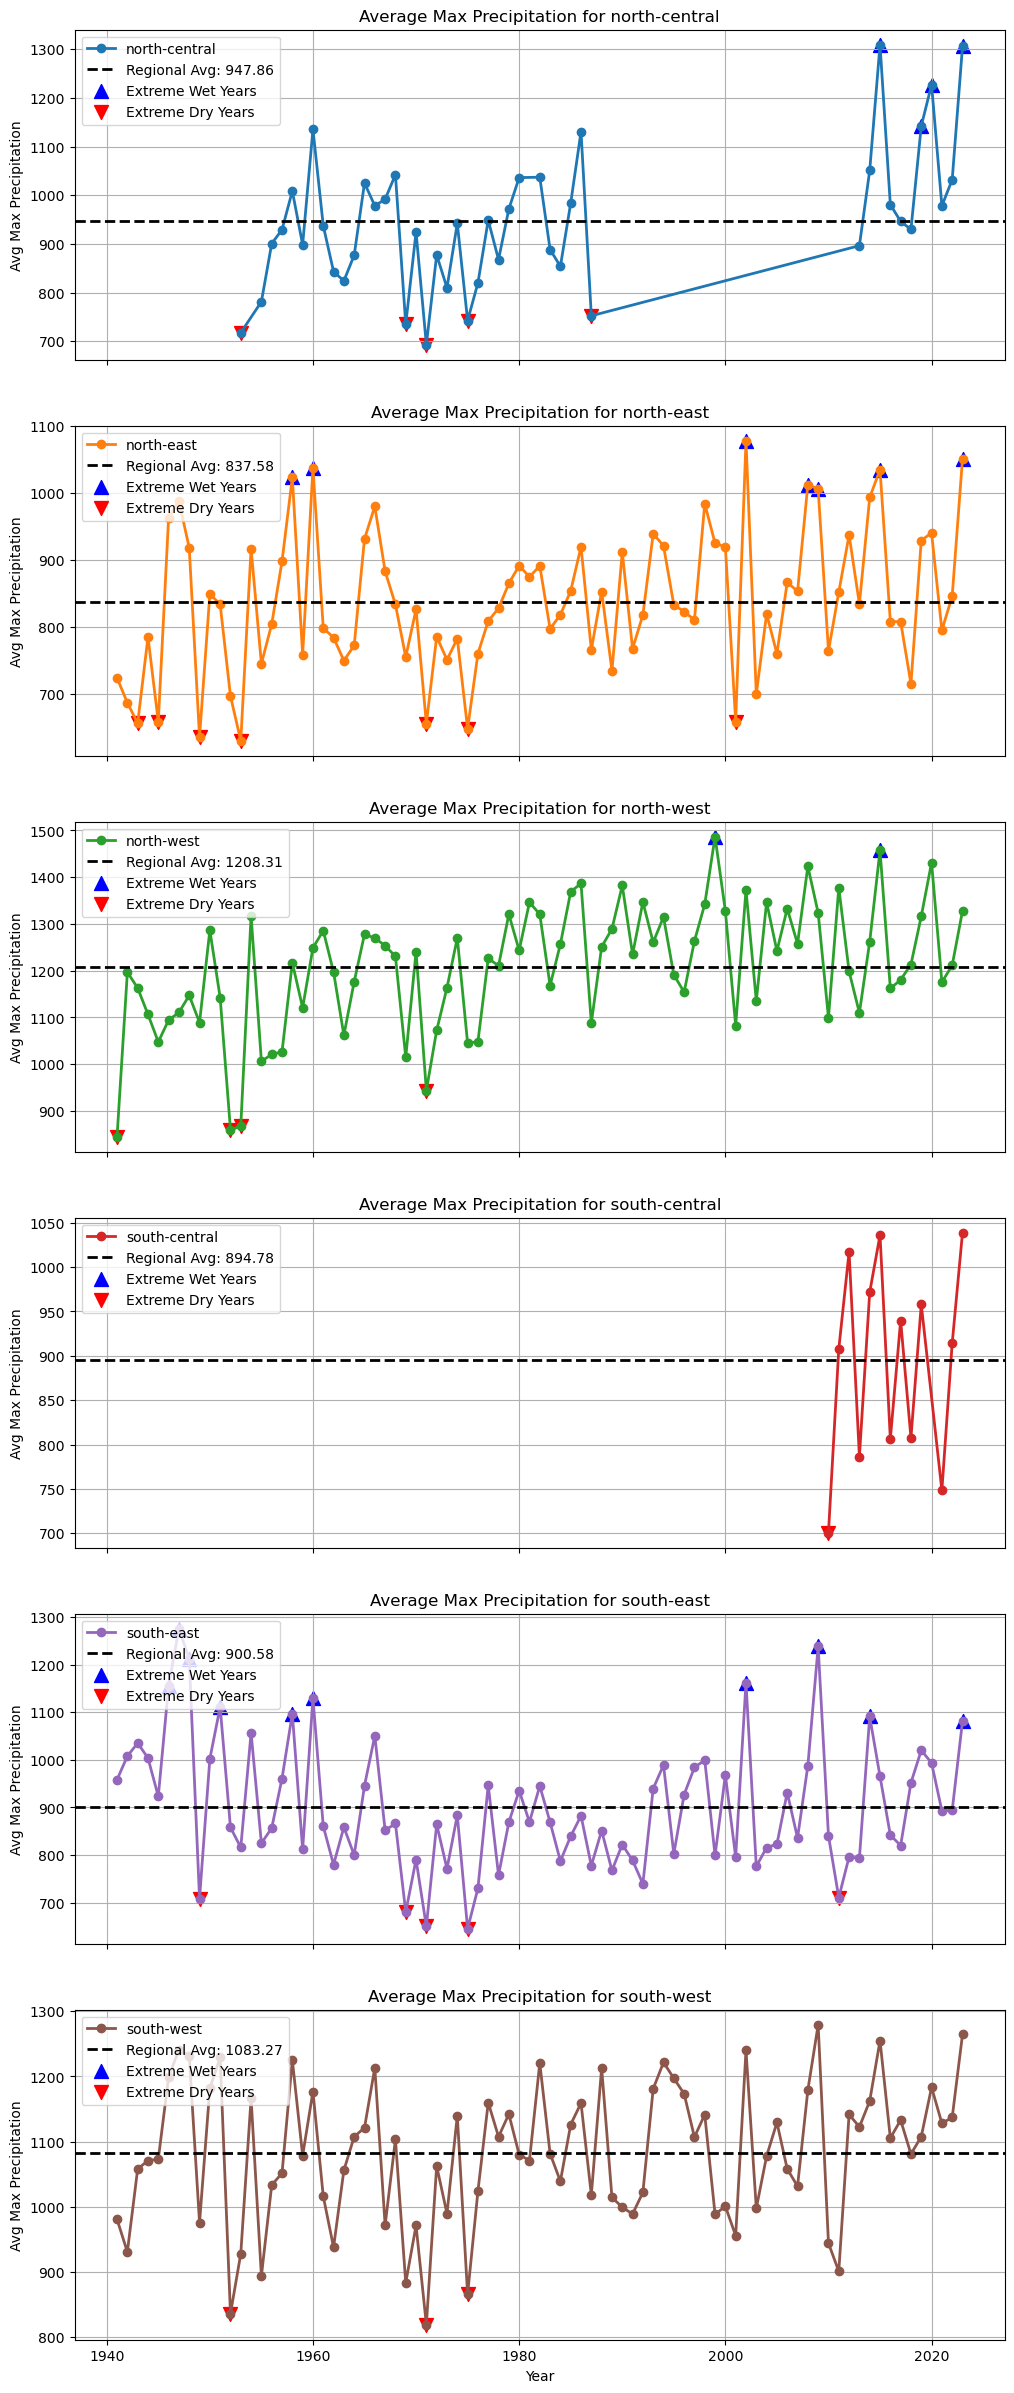

In [95]:
# Define the threshold percentage
threshold_percentage = 20 / 100  # 20%

# Define the threshold percentage
threshold_percentage = 20 / 100  # 20%

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Define a color map
colors = plt.get_cmap('tab10')
color_list = colors(range(len(regions)))

# Create subplots
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(12, 5 * len(regions)), sharex=True)

# Plot each region in a separate subplot
for i, (region, color) in enumerate(zip(regions, color_list)):
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Plot yearly average max precipitation
    axes[i].plot(region_data['Year'], region_data['Avg Max Precipitation'], marker='o', color=color, label=region, linewidth=2)

    # Add baseline
    baseline = average_precipitation_by_region[average_precipitation_by_region['Region'] == region]['Avg Max Precipitation'].values[0]
    axes[i].axhline(y=baseline, color='black', linestyle='--', label=f'Regional Avg: {baseline:.2f}', linewidth=2)

    # Define thresholds
    extreme_wet_threshold = baseline * (1 + threshold_percentage)
    extreme_dry_threshold = baseline * (1 - threshold_percentage)

    # Highlight extreme wet years
    wet_years = region_data[region_data['Avg Max Precipitation'] > extreme_wet_threshold]
    axes[i].scatter(wet_years['Year'], wet_years['Avg Max Precipitation'], color='blue', marker='^', label='Extreme Wet Years', s=100)

    # Highlight extreme dry years
    dry_years = region_data[region_data['Avg Max Precipitation'] < extreme_dry_threshold]
    axes[i].scatter(dry_years['Year'], dry_years['Avg Max Precipitation'], color='red', marker='v', label='Extreme Dry Years', s=100)

    # Set plot details
    axes[i].set_title(f'Average Max Precipitation for {region}')
    axes[i].set_ylabel('Avg Max Precipitation')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

# Set common x-label
axes[-1].set_xlabel('Year')

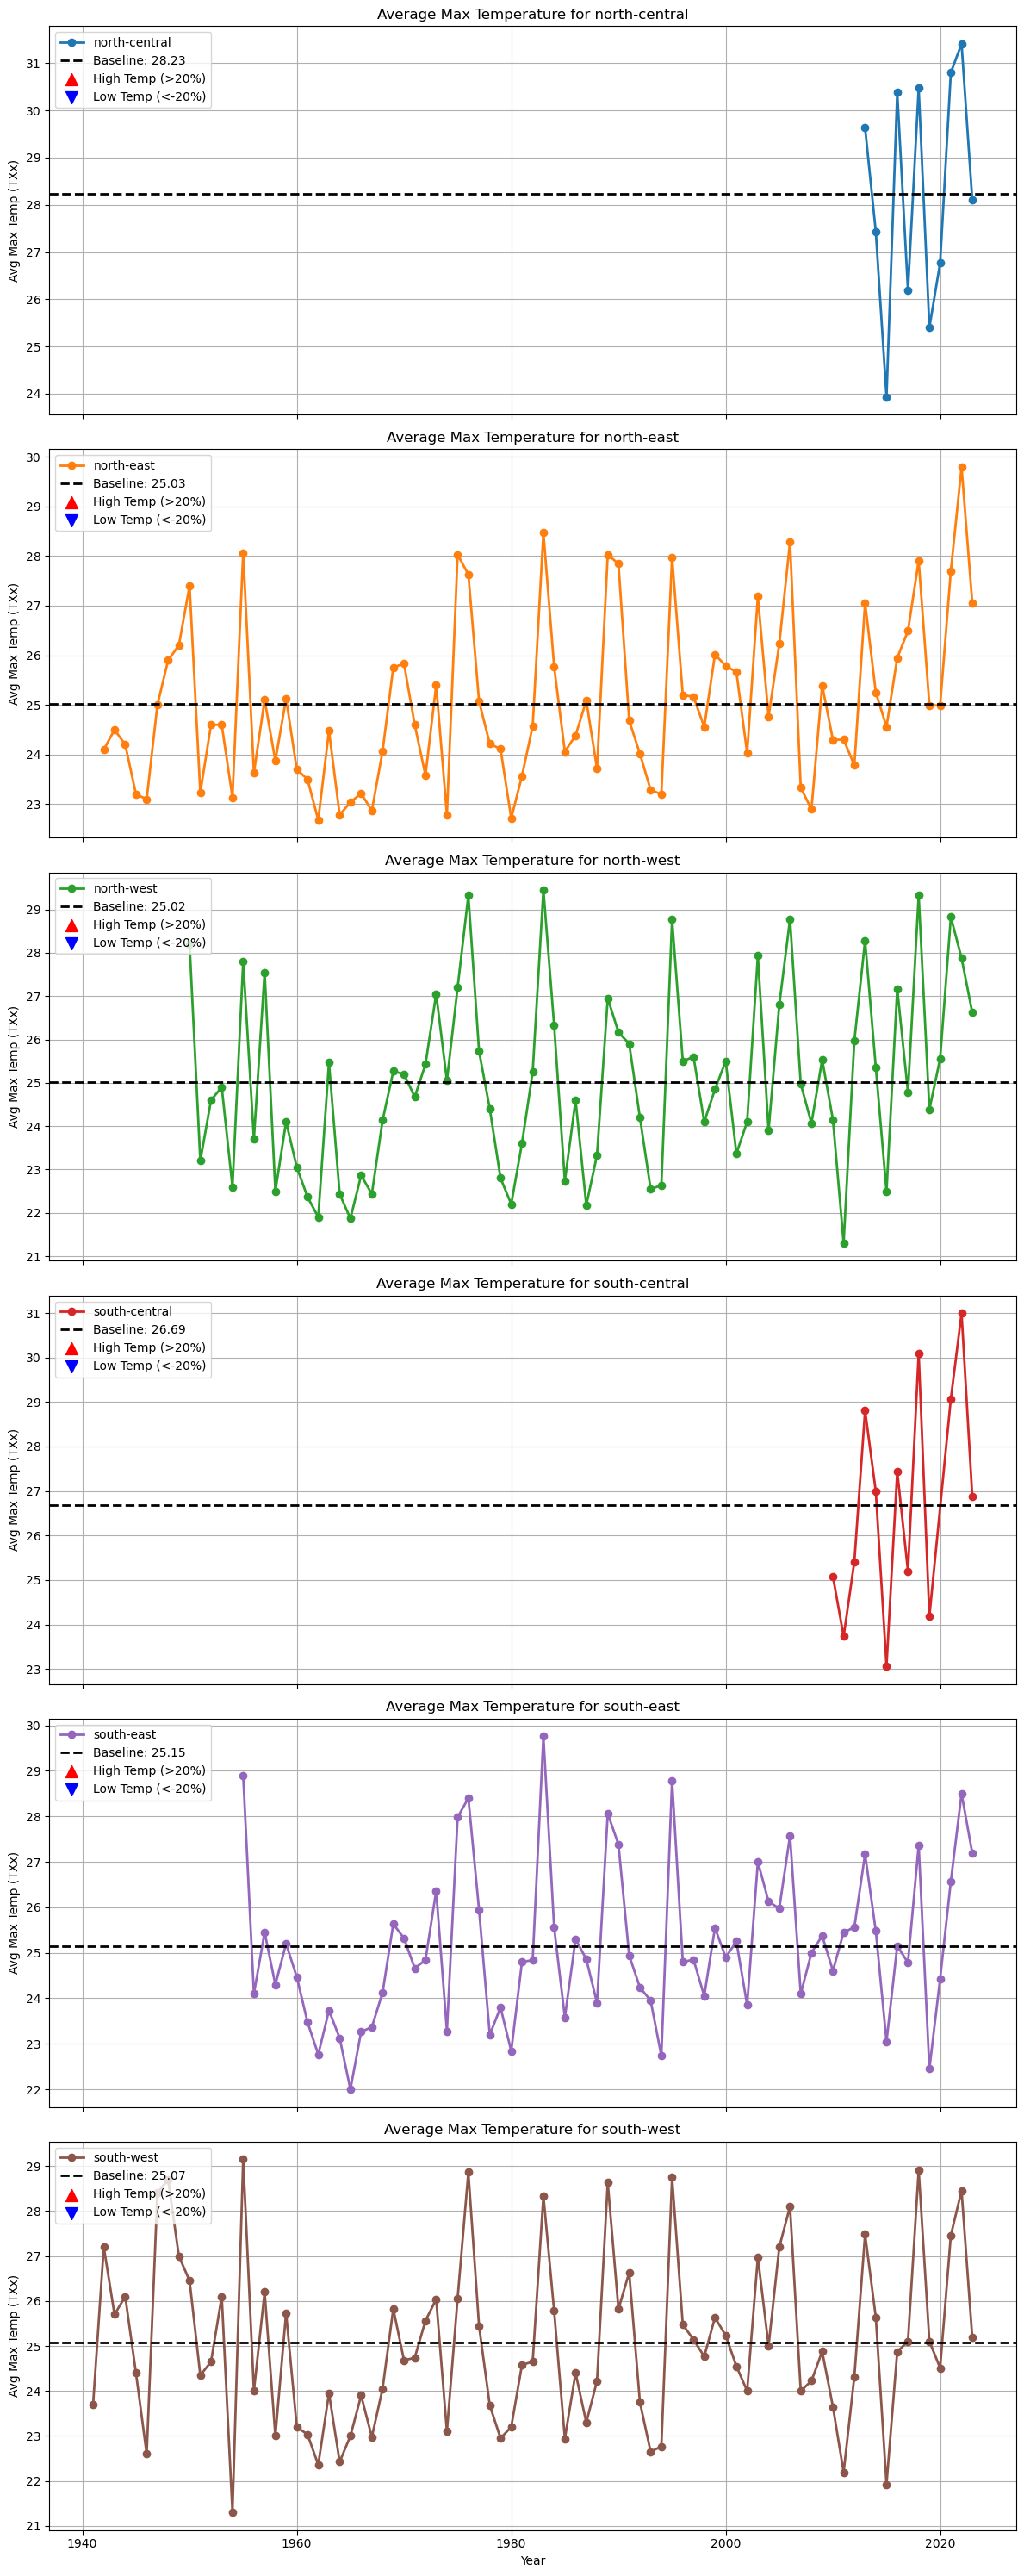

In [96]:

# Define the threshold percentage for extreme temperature
threshold_percentage = 20 / 100  # 20%

# Define the baselines for each region as provided
baselines = {
    'north-central': 28.228182,
    'north-east': 25.028242,
    'north-west': 25.023113,
    'south-central': 26.688462,
    'south-east': 25.150338,
    'south-west': 25.071878
}

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Define a color map
colors = plt.get_cmap('tab10')
color_list = colors(range(len(regions)))

# Create subplots for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(12, 5 * len(regions)), sharex=True)

# Plot each region in a separate subplot
for i, (region, color) in enumerate(zip(regions, color_list)):
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Plot yearly average maximum temperature
    axes[i].plot(region_data['Year'], region_data['Avg Max Temp'], marker='o', color=color, label=region, linewidth=2)

    # Get the baseline for the current region
    baseline = baselines[region]

    # Add baseline to the plot
    axes[i].axhline(y=baseline, color='black', linestyle='--', label=f'Baseline: {baseline:.2f}', linewidth=2)

    # Define thresholds for high and low temperatures
    high_threshold = baseline * (1 + threshold_percentage)
    low_threshold = baseline * (1 - threshold_percentage)

    # Highlight temperatures above the high threshold
    high_temps = region_data[region_data['Avg Max Temp'] > high_threshold]
    axes[i].scatter(high_temps['Year'], high_temps['Avg Max Temp'], color='red', marker='^', label='High Temp (>20%)', s=100)

    # Highlight temperatures below the low threshold
    low_temps = region_data[region_data['Avg Max Temp'] < low_threshold]
    axes[i].scatter(low_temps['Year'], low_temps['Avg Max Temp'], color='blue', marker='v', label='Low Temp (<-20%)', s=100)

    # Set plot details
    axes[i].set_title(f'Average Max Temperature for {region}')
    axes[i].set_ylabel('Avg Max Temp (TXx)')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

# Set common x-label
axes[-1].set_xlabel('Year')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



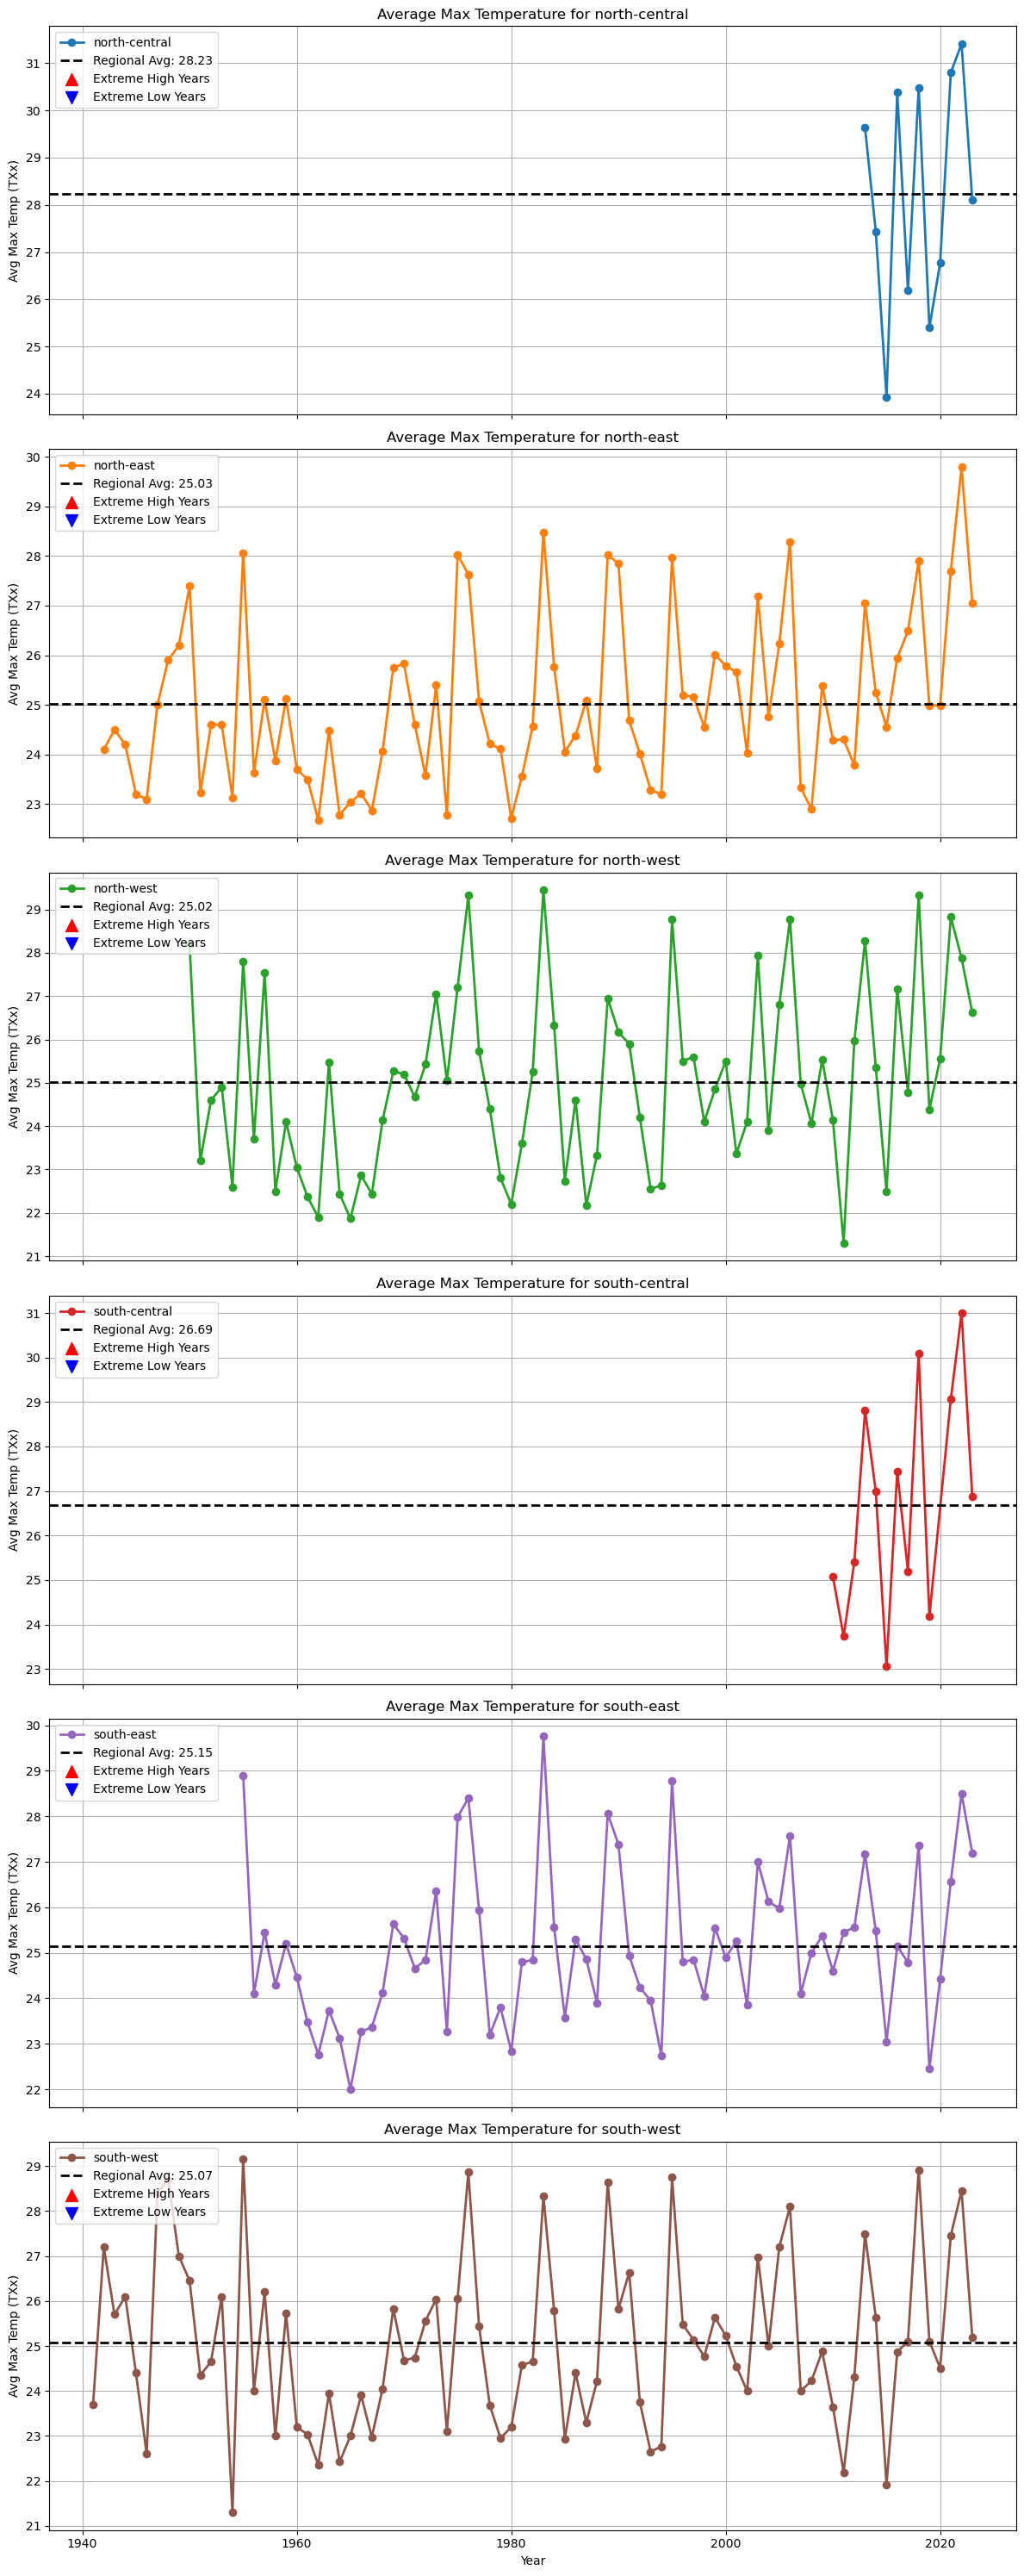

In [97]:

# Define the threshold percentage for extreme temperature
threshold_percentage = 20 / 100  # 20%

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Define a color map
colors = plt.get_cmap('tab10')
color_list = colors(range(len(regions)))

# Create subplots for each region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(12, 5 * len(regions)), sharex=True)

# Plot each region in a separate subplot
for i, (region, color) in enumerate(zip(regions, color_list)):
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Plot yearly average maximum temperature
    axes[i].plot(region_data['Year'], region_data['Avg Max Temp'], marker='o', color=color, label=region, linewidth=2)

    # Add baseline (regional average temperature)
    baseline = regional_avg_by_year[regional_avg_by_year['Region'] == region]['Avg Max Temp'].mean()
    axes[i].axhline(y=baseline, color='black', linestyle='--', label=f'Regional Avg: {baseline:.2f}', linewidth=2)

    # Define thresholds for extreme temperatures
    extreme_high_threshold = baseline * (1 + threshold_percentage)
    extreme_low_threshold = baseline * (1 - threshold_percentage)

    # Highlight extreme high temperature years
    high_temp_years = region_data[region_data['Avg Max Temp'] > extreme_high_threshold]
    axes[i].scatter(high_temp_years['Year'], high_temp_years['Avg Max Temp'], color='red', marker='^', label='Extreme High Years', s=100)

    # Highlight extreme low temperature years
    low_temp_years = region_data[region_data['Avg Max Temp'] < extreme_low_threshold]
    axes[i].scatter(low_temp_years['Year'], low_temp_years['Avg Max Temp'], color='blue', marker='v', label='Extreme Low Years', s=100)

    # Set plot details
    axes[i].set_title(f'Average Max Temperature for {region}')
    axes[i].set_ylabel('Avg Max Temp (TXx)')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

# Set common x-label
axes[-1].set_xlabel('Year')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# 3. Trend Analysis by Region

## Modified Mann-Kendall test

In [42]:
import numpy as np
import pymannkendall as mk
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cleaned_df is your DataFrame with all the data
# Columns of interest: 'Direction' (Region), 'Year', 'PRCPTOT' (Precipitation), 'TXx' (Max Temp)

# Group data by region and year to calculate the mean for PRCPTOT and TXx
regional_avg_by_year = cleaned_df.groupby(['Direction', 'year'])[['PRCPTOT', 'TXx']].mean().reset_index()
regional_avg_by_year.columns = ['Region', 'Year', 'Avg Precipitation', 'Avg Max Temp']

# Get unique regions
regions = regional_avg_by_year['Region'].unique()

# Iterate over each region
for region in regions:
    # Extract data for the region
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Perform the Mann-Kendall test for PRCPTOT (precipitation)
    precip_result = mk.hamed_rao_modification_test(region_data['Avg Precipitation'].values)

    # Perform the Mann-Kendall test for TXx (maximum temperature)
    temp_result = mk.hamed_rao_modification_test(region_data['Avg Max Temp'].values)

    # Print the results along with the region name
    print(f"Region: {region}")
    print(f"Precipitation Mann-Kendall Test Result: {precip_result}")
    print(f"Temperature Mann-Kendall Test Result: {temp_result}")
    print("-" * 50)




Region: north-central
Precipitation Mann-Kendall Test Result: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.005508467328994904, z=2.7756901751244265, Tau=0.27465986394557823, s=323.0, var_s=13457.666666666666, slope=1.1534736842105269, intercept=209.51663157894734)
Temperature Mann-Kendall Test Result: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.5021582515007486, z=0.6710977636952193, Tau=0.15384615384615385, s=12.0, var_s=268.6666666666667, slope=0.04425000000000008, intercept=20.448999999999995)
--------------------------------------------------
Region: north-east
Precipitation Mann-Kendall Test Result: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0003113422345562, z=3.605675299369796, Tau=0.21457257601835916, s=748.0, var_s=42920.816395856025, slope=0.3911134702328132, intercept=191.65715305430376)
Temperature Mann-Kendall Test Result: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend

## Combined Trends of Precipitation and Temperature by Region

This analysis performs the Mann-Kendall trend test on precipitation and maximum temperature data for various regions to evaluate their trends. Results are compiled into a DataFrame, showcasing trends, p-values, and tau coefficients for both precipitation and temperature. Two subplots visualize the trends over time for each region: one for average precipitation and another for maximum temperature, with clear labels and legends for easy comparison.

       Region Precipitation Trend  Precipitation p-value  Precipitation Tau  \
0  south-west            no trend               0.612811           0.037866   

  Temperature Trend  Temperature p-value  Temperature Tau  
0          no trend             0.066091         0.128514  


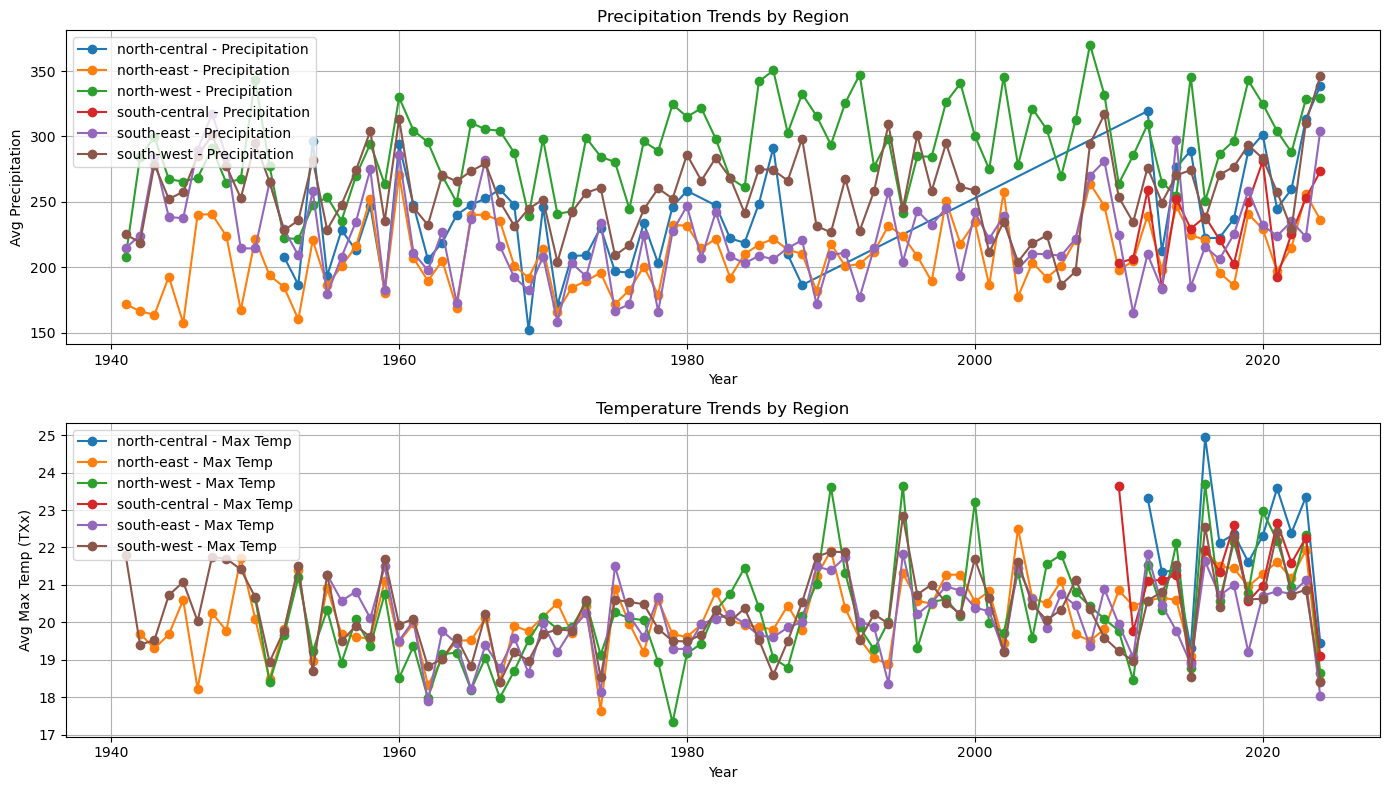

In [43]:

# Initialize an empty list to store the results
trend_results = []

# Iterate over each region
for region in regions:
    # Extract data for the region
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Perform the Mann-Kendall test for PRCPTOT (precipitation)
    precip_result = mk.hamed_rao_modification_test(region_data['Avg Precipitation'].values)

    # Perform the Mann-Kendall test for TXx (maximum temperature)
    temp_result = mk.hamed_rao_modification_test(region_data['Avg Max Temp'].values)

# Append the results to the list
trend_results.append({
        'Region': region,
        'Precipitation Trend': precip_result.trend,
        'Precipitation p-value': precip_result.p,
        'Precipitation Tau': precip_result.Tau,
        'Temperature Trend': temp_result.trend,
        'Temperature p-value': temp_result.p,
        'Temperature Tau': temp_result.Tau
    })

# Convert trend_results to a DataFrame for better readability
trend_results_df = pd.DataFrame(trend_results)

# Display the trend results
print(trend_results_df)

# Step 3: Plot the Trends for each region
plt.figure(figsize=(14, 8))

for region in regions:
    region_data = regional_avg_by_year[regional_avg_by_year['Region'] == region]

    # Plot Precipitation Trend
    plt.subplot(2, 1, 1)
    plt.plot(region_data['Year'], region_data['Avg Precipitation'], marker='o', label=f'{region} - Precipitation')
    plt.xlabel('Year')
    plt.ylabel('Avg Precipitation')
    plt.title('Precipitation Trends by Region')
    plt.legend(loc='best')
    plt.grid(True)

    # Plot Temperature Trend
    plt.subplot(2, 1, 2)
    plt.plot(region_data['Year'], region_data['Avg Max Temp'], marker='o', label=f'{region} - Max Temp')
    plt.xlabel('Year')
    plt.ylabel('Avg Max Temp (TXx)')
    plt.title('Temperature Trends by Region')
    plt.legend(loc='best')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
!pip install ruptures


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [45]:
regional_avg_by_year.columns

Index(['Region', 'Year', 'Avg Precipitation', 'Avg Max Temp'], dtype='object')